<a target="_blank" href="https://colab.research.google.com/github/markusmeister/MIB-R/blob/master/python/Figures_Ch_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Ch 2 - Basics of Linear Algebra

This notebook contains python code for generating figures in Chapter 2 of the book _Mathematics in Biology_.

## Imports and utilities

In [1]:
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('../img')
    savedir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

## Basics

In [7]:
import pickle
import urllib.request

url = "https://github.com/markusmeister/MIB-R/blob/master/data/Impulses2"
# url = "https://github.com/markusmeister/Aliasing/blob/master/requirements.txt"

# Fetch the data from the URL
response = urllib.request.urlopen(url)

HTTPError: HTTP Error 404: Not Found

In [5]:
response.read()

b'\n\n\n\n\n\n<!DOCTYPE html>\n<html\n  lang="en"\n  \n  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"\n  data-a11y-animated-images="system" data-a11y-link-underlines="true"\n  \n  >\n\n\n\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch" href="https://github.githubassets.com">\n  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">\n  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">\n  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>\n  <link rel="preconnect" href="https://avatars.githubusercontent.com">\n\n  \n\n\n  <link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/light-0cfd1fd8509e.css" /><link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/dark-d782f59290e2.css" /><link data-color-theme="dark_di

In [2]:
data = response.read()

# Load the pickled data
loaded_data = pickle.loads(data)

print(loaded_data)

HTTPError: HTTP Error 404: Not Found

### Introduction

In [5]:
str(datadir)

'../data'

In [8]:
# load data 
fn=str(datadir)+'/Impulses2'
with open(fn,'rb') as f:
    (Lx,Ly),(Bx,By),(Jx,Jy),(Gx,Gy),(Cx,Cy),(Kx,Ky)=pickle.load(f)

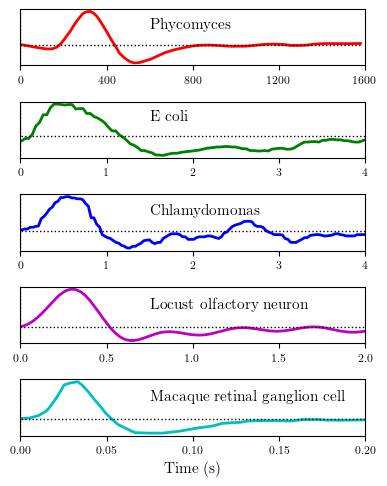

In [9]:
# plot and save
# # Include the second macaque cell (Kx,Ky)
fig,axes=plt.subplots(nrows=5,figsize=(4,5))
data=zip([Lx,Bx,Jx,Gx,Kx],[Ly,By,Jy,Gy,Ky])
fmts=['r-','g-','b-','m-','c-']
sign=[1,1,-2,-2,1]
xlim=[1600,4,4,2,0.2]

for ax,(x,y),s,f,l in zip(axes,data,sign,fmts,xlim):
    y1=s*y/np.max(s*y) # make positive and scale to max of 1
    plot(x,y1,fmts=[f],axes=ax);
    plot([x[0],x[-1]],[0,0],fmts=['k:'],linewidth=1,axes=ax);
    plot([0,0],[np.min(y1),np.max(y1)],fmts=['k:'],linewidth=1,axes=ax);
    ax.set_xlim([0,l])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='x',labelsize=8)
ax.set_xlabel('Time (s)')
axes[0].text(600,0.5,'Phycomyces');
axes[1].text(1.5,0.5,'E coli');
axes[2].text(1.5,0.5,'Chlamydomonas');
axes[3].text(0.75,0.5,'Locust olfactory neuron');
axes[4].text(0.075,0.5,'Macaque retinal ganglion cell');
plt.tight_layout()
plt.savefig(str(savedir)+'/Impulses2.pdf',bbox_inches='tight')

### Linear Algebra

#### Linear operators

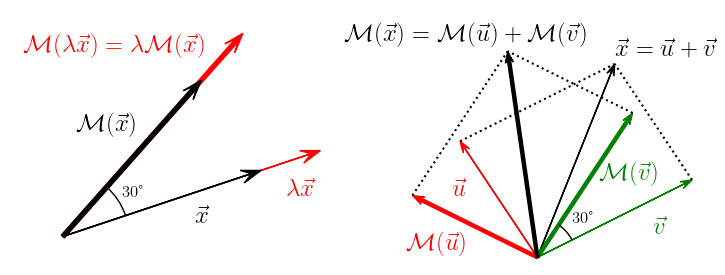

In [2]:
from matplotlib.patches import Arc

def plot0(ax):
    x=[1.5,.5]
    an=30
    la=1.3
    c=np.cos(an*np.pi/180)
    s=np.sin(an*np.pi/180)
    Mx=[x[0]*c-x[1]*s,x[0]*s+x[1]*c]
#     fig,ax=plt.subplots(1,1,figsize=(4,4))
    ax.arrow(0,0,la*x[0],la*x[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,la*Mx[0],la*Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.arrow(0,0,Mx[0],Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.add_patch(Arc((0,0),1,1,0,
                     np.arctan(x[1]/x[0])*180/np.pi,
                     np.arctan(Mx[1]/Mx[0])*180/np.pi, 
                     linewidth=1, color='black')) # draw arc
    ax.text(0.45,0.3,'{:.0f}°'.format(an),fontsize=12)
    ax.text(1.,0.1,r'$\vec x$',fontsize=18)
    ax.text(1.7,0.3,r'$\lambda \vec x$',color='red',fontsize=18)
    ax.text(0.1,0.8,r'$\mathcal{M}(\vec x)$',fontsize=18)
    ax.text(-0.3,1.4,r'$\mathcal{M}(\lambda \vec x) = \lambda \mathcal{M}(\vec x)$',color='red',fontsize=18)
    ax.set_xlim((-0.4,2.0))
    ax.set_ylim((-0.1,1.6))
    ax.set_aspect('equal')
    ax.axis('off')
#     plt.show()

def plot1(ax):
    v=np.array([2,1])
    u=np.array([-1,1.5])
    an=30.0
    x=u+v
    c=np.cos(an*np.pi/180)
    s=np.sin(an*np.pi/180)
    M=np.array([[c,-s],[s,c]])
    Mv=M.dot(v)
    Mu=M.dot(u)
    Mx=M.dot(x)
#     fig,ax=plt.subplots(1,1,figsize=(4,4))
    ax.arrow(0,0,u[0],u[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,v[0],v[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='green')
    ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.arrow(0,0,Mu[0],Mu[1],width=0.04,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,Mv[0],Mv[1],width=0.04,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='green')
    ax.arrow(0,0,Mx[0],Mx[1],width=0.04,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.plot([u[0],x[0]],[u[1],x[1]],'k:')
    ax.plot([v[0],x[0]],[v[1],x[1]],'k:')
    ax.plot([Mu[0],Mx[0]],[Mu[1],Mx[1]],'k:')
    ax.plot([Mv[0],Mx[0]],[Mv[1],Mx[1]],'k:')
    ax.add_patch(Arc((0,0),1,1,0,
                     np.arctan(v[1]/v[0])*180/np.pi,
                     np.arctan(Mv[1]/Mv[0])*180/np.pi, 
                     linewidth=1, color='black')) # draw arc
    ax.text(0.45,0.45,'{:.0f}°'.format(an),fontsize=12)
    ax.text(1.,2.6,r'$\vec x = \vec u + \vec v$',fontsize=18)
    ax.text(1.5,0.3,r'$\vec v$',fontsize=18,color='green')
    ax.text(-1.1,0.8,r'$\vec u$',fontsize=18,color='red')
    ax.text(0.8,1.0,r'$\mathcal{M}(\vec v)$',fontsize=18,color='green')
    ax.text(-1.7,.1,r'$\mathcal{M}(\vec u)$',fontsize=18,color='red')
    ax.text(-2.5,2.8,r'$\mathcal{M}(\vec x) = \mathcal{M}(\vec u) + \mathcal{M}(\vec v)$',fontsize=18,color='black')
    ax.set_xlim((-1.9,2.2))
    ax.set_ylim((-0.1,3.2))
    ax.set_aspect('equal')
    ax.axis('off')
#     plt.show()

fig,ax=plt.subplots(1,2,figsize=(9,4))
plot0(ax[0])
plot1(ax[1])
fig.savefig(str(savedir / 'rotation-arrows-30deg.pdf'), dpi=600, format='pdf', bbox_inches='tight');

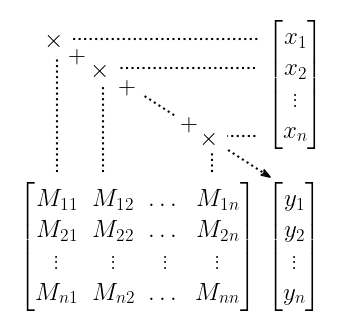

In [3]:
# mnemonic matrix * vector
# import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams['font.size'] = 12
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

fig,ax = plt.subplots(figsize=(4,4))

# ax.plot([.25,.25],[.4,.8],'k:')
ax.text(.2,.2,r'$\begin{bmatrix} M_{11} & M_{12} & \dots & M_{1n} \\ M_{21} & M_{22} & \dots & M_{2n} \\ \vdots & \vdots & \vdots & \vdots\\ M_{n1} & M_{n2} & \dots & M_{nn} \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.7,r'$\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.2,r'$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}$',
        fontsize=18,color='black')
ax.plot([0.3,0.3,0.95],[0.45,0.86,0.86],'k:')
ax.plot([0.45,0.45,0.95],[0.45,0.77,0.77],'k:')
ax.plot([0.8,0.8,0.95],[0.45,0.56,0.56],'k:')
ax.text(0.3,.86,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.45,.77,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.8,.56,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.37,.805,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.53,.71,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.73,.595,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.plot([0.3,0.98],[0.86,0.44],'k:')
ax.arrow(0.98,0.44,0.01,-0.006,width=0.001,length_includes_head=True,head_width=0.02,
        overhang=0.2)
ax.set_xlim(0.15,1.15)
ax.set_ylim(0,0.95)
ax.axis('off')

fig.savefig(str(savedir / 'matrix-times-vector.pdf'), dpi=600, format='pdf', bbox_inches='tight');

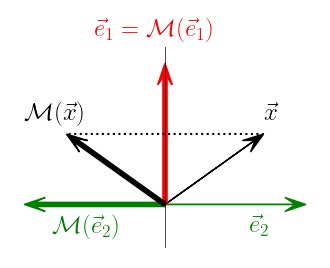

In [4]:
# reflection operator
e1=np.array([0,1])
e2=np.array([1,0])
x=np.array([.7,0.5])
Mx=np.array([-x[0],x[1]])
Me1=np.array([0,1])
Me2=np.array([-1,0])

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.arrow(0,0,e1[0],e1[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,e2[0],e2[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.arrow(0,0,Me1[0],Me1[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,Me2[0],Me2[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,Mx[0],Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.plot([x[0],Mx[0]],[x[1],Mx[1]],'k:')
ax.plot([0,0],[-.3,1.3],'k-',linewidth=0.5)
ax.text(0.7,0.6,r'$\vec x$',fontsize=18)
ax.text(-1,0.6,r'$\mathcal{M}(\vec x)$',fontsize=18)
ax.text(-0.5,1.2,r'$\vec e_1 = \mathcal{M}(\vec e_1)$',
        bbox=dict(facecolor='white',linewidth=0),
        fontsize=18,color='red')
ax.text(0.6,-0.2,r'$\vec e_2$',fontsize=18,color='green')
ax.text(-0.8,-0.2,r'$\mathcal{M}(\vec e_2)$',fontsize=18,color='green')
# ax.set_xlim((-1.9,2.2))
# ax.set_ylim((-0.1,3.2))
ax.set_aspect('equal')
ax.axis('off')
fig.savefig(str(savedir / 'arrow-reflection.pdf'), dpi=600, format='pdf', bbox_inches='tight');

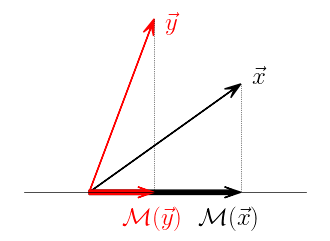

In [5]:
# projection operator
x=np.array([.7,0.5])
y=np.array([.3,0.8])
Mx=np.array([x[0],0])
My=np.array([y[0],0])

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='black')
ax.arrow(0,0,Mx[0],Mx[1],width=0.02,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='black')
ax.arrow(0,0,y[0],y[1],width=0.001,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='red')
ax.arrow(0,0,My[0],My[1],width=0.02,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='red')
ax.plot([-.3,1],[0,0],'k-',linewidth=0.5)
ax.plot([x[0],Mx[0]],[x[1],Mx[1]],'k:',linewidth=0.5)
ax.plot([y[0],My[0]],[y[1],My[1]],'k:',linewidth=0.5)
ax.text(0.75,0.5,r'$\vec x$',fontsize=18)
ax.text(0.35,0.75,r'$\vec y$',fontsize=18,color='red')
ax.text(0.5,-0.15,r'$\mathcal{M}(\vec x)$',fontsize=18)
ax.text(0.15,-0.15,r'$\mathcal{M}(\vec y)$',fontsize=18,color='red')
# ax.set_xlim((-1.9,2.2))
# ax.set_ylim((-0.1,3.2))
ax.set_aspect('equal')
ax.axis('off')
fig.savefig(str(savedir / 'arrow-projection.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### Matrix algebra

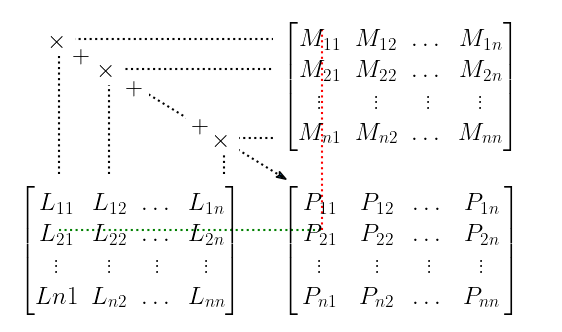

In [6]:
# mnemonic matrix * vector
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# mpl.rcParams['font.size'] = 12
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

fig,ax = plt.subplots(figsize=(7,7))

# ax.plot([.25,.25],[.4,.8],'k:')
ax.text(.2,.2,r'$\begin{bmatrix} L_{11} & L_{12} & \dots &L_{1n} \\ L_{21} & L_{22} & \dots & L_{2n} \\ \vdots & \vdots & \vdots & \vdots\\ L{n1} & L_{n2} & \dots & L_{nn} \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.7,r'$\begin{bmatrix} M_{11} & M_{12} & \dots & M_{1n} \\ M_{21} & M_{22} & \dots & M_{2n} \\ \vdots & \vdots & \vdots & \vdots\\ M_{n1} & M_{n2} & \dots & M_{nn} \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.2,r'$\begin{bmatrix} \,P_{11}\, & \,P_{12}\, & \dots & \,P_{1n}\, \\ \,P_{21}\, & \,P_{22}\, & \dots & \,P_{2n}\, \\ \vdots & \vdots & \vdots & \vdots\\ \,P_{n1}\, & \,P_{n2}\, & \dots & \,P_{nn}\, \end{bmatrix}$',
        fontsize=18,color='black')
ax.plot([0.3,0.3,0.95],[0.45,0.86,0.86],'k:')
ax.plot([0.45,0.45,0.95],[0.45,0.77,0.77],'k:')
ax.plot([0.8,0.8,0.95],[0.45,0.56,0.56],'k:')
ax.text(0.3,.86,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.45,.77,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.8,.56,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.37,.805,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.53,.71,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.73,.595,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.plot([0.3,0.98],[0.86,0.44],'k:')
ax.arrow(0.98,0.44,0.01,-0.006,width=0.001,length_includes_head=True,head_width=0.02,
        overhang=0.2)
ax.plot([1.1,1.1],[0.28,0.9],'r:')
ax.plot([0.3,1.1],[0.28,0.28],'g:')
ax.set_xlim(0.15,1.8)
ax.set_ylim(0,0.95)
ax.set_aspect('equal')
ax.axis('off')
fig.savefig(str(savedir / 'matrix-times-matrix.pdf'), dpi=600, format='pdf', bbox_inches='tight');

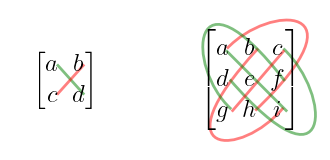

In [7]:
# import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# mpl.rcParams['font.size'] = 12
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

def Det3D(ax):
    # determinant in 3D mnemonic; uses Bezier curves
    x=np.array([.7,0.5])
    y=np.array([.3,0.8])
    Mx=np.array([x[0],0])
    My=np.array([y[0],0])

    ax.text(.18,.21,r'$\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \end{bmatrix}$',
            fontsize=18,color='black')

    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
    ]

    verts1 = np.array([
       (0.25, 0.34),   # P0
       (0.4, 0.5),  # P1
       (0.75, 0.5),  # P2
       (0.35, 0.12),  # P3
    ])
    path1 = Path(verts1, codes)
    patch1 = patches.PathPatch(path1, facecolor='none', lw=2,edgecolor='red',alpha=0.5)
    ax.add_patch(patch1)

    verts2 = np.array(
      [[ 0.45,  0.13],
       [ 0.3 , -0.05],
       [ 0.  , -0.05],
       [ 0.36,  0.34]]
    )
    path2 = Path(verts2, codes)
    patch2 = patches.PathPatch(path2, facecolor='none', lw=2,edgecolor='red',alpha=0.5)
    ax.add_patch(patch2)
    
    verts3 = np.array(
      [[0.265, 0.125],
       [0.1, 0.275],
       [0.12, 0.66],
       [0.455, 0.225]]
    )
    path3 = Path(verts3, codes)
    patch3 = patches.PathPatch(path3, facecolor='none', lw=2,edgecolor='green',alpha=0.5)
    ax.add_patch(patch3)

    verts4 = np.array(
      [[ 0.45,  0.34],
       [ 0.625,  0.175],
       [ 0.625, -0.19],
       [ 0.26,  0.23]]
    )
    path4 = Path(verts4, codes)
    patch4 = patches.PathPatch(path4, facecolor='none', lw=2,edgecolor='green',alpha=0.5)
    ax.add_patch(patch4)

    diag=np.array([[.27,.12],[.45,.33]])
    ax.plot(diag.T[0],diag.T[1],color='red',alpha=0.5, lw=2)

    diag2=np.array([
        [0.25, 0.33],
        [0.46, 0.12]
    ])
    ax.plot(diag2.T[0],diag2.T[1],color='green',alpha=0.5, lw=2)

    ax.set_xlim((0.08,0.58))
    ax.set_ylim((-0.02,0.48))
    ax.set_aspect('equal')
    ax.axis('off')
    
def Det2D(ax):
    # determinant in 2D mnemonic

    ax.text(.18,.21,r'$\begin{bmatrix} a & b \\ c & d\end{bmatrix}$',
            fontsize=18,color='black')
    diag=np.array([[.25,.28],[.34,.18]])
    ax.plot([diag[0,0],diag[1,0]],[diag[0,1],diag[1,1]],color='green',alpha=0.5, lw=2)
    ax.plot([diag[0,0],diag[1,0]],[diag[1,1],diag[0,1]],color='red',alpha=0.5, lw=2)
    ax.set_xlim((0.08,0.58))
    ax.set_ylim((-0.02,0.48))
    ax.set_aspect('equal')
    ax.axis('off')

    
fig,ax=plt.subplots(1,2,figsize=(4,2))
Det2D(ax[0])
Det3D(ax[1])

fig.savefig(str(savedir / 'determinant-mnemonic.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### Change of basis

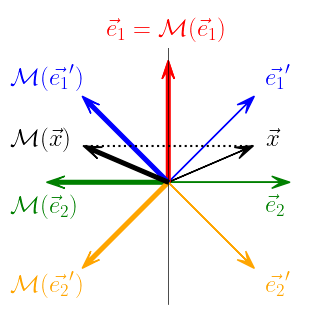

In [8]:
# reflection operator new basis
s2=1/np.sqrt(2)
e1=np.array([0,1])
e2=np.array([1,0])
f1=np.array([s2,s2])
f2=np.array([s2,-s2])

x=np.array([.7,0.3])
Mx=np.array([-x[0],x[1]])
Me1=np.array([0,1])
Me2=np.array([-1,0])
Mf1=np.array([-s2,s2])
Mf2=np.array([-s2,-s2])

fig,ax=plt.subplots(1,1,figsize=(4,4))

ax.arrow(0,0,e1[0],e1[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,e2[0],e2[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,f1[0],f1[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='blue')
ax.arrow(0,0,f2[0],f2[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='orange')
ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.arrow(0,0,Me1[0],Me1[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,Me2[0],Me2[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,Mf1[0],f1[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='blue')
ax.arrow(0,0,Mf2[0],f2[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='orange')
ax.arrow(0,0,Mx[0],Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.plot([x[0],Mx[0]],[x[1],Mx[1]],'k:')
ax.plot([0,0],[-1.,1.3],'k-',linewidth=0.5)
ax.text(0.8,0.3,r'$\vec x$',fontsize=18)
ax.text(-1.3,0.3,r'$\mathcal{M}(\vec x)$',fontsize=18)
ax.text(-0.5,1.2,r'$\vec e_1 = \mathcal{M}(\vec e_1)$',
        bbox=dict(facecolor='white',linewidth=0),
        fontsize=18,color='red')
ax.text(0.8,-0.25,r'$\vec e_2$',fontsize=18,color='green')
ax.text(-1.3,-0.25,r'$\mathcal{M}(\vec e_2)$',fontsize=18,color='green')
ax.text(0.8,0.8,r'${:s}$'.format('\\vec {e_1}\''),fontsize=18,color='blue')
ax.text(-1.3,0.8,r'${:s}$'.format('\\mathcal{M}(\\vec {e_1}\')'),fontsize=18,color='blue')
ax.text(0.8,-0.9,r'${:s}$'.format('\\vec {e_2}\''),fontsize=18,color='orange')
ax.text(-1.3,-0.9,r'${:s}$'.format('\\mathcal{M}(\\vec {e_2}\')'),fontsize=18,color='orange')
# ax.set_xlim((-1.9,2.2))
# ax.set_ylim((-0.1,3.2))
ax.set_aspect('equal')
ax.axis('off')

fig.savefig(str(savedir / 'reflection-basis-transform.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Advanced

### Linear systems analysis

#### Convolution

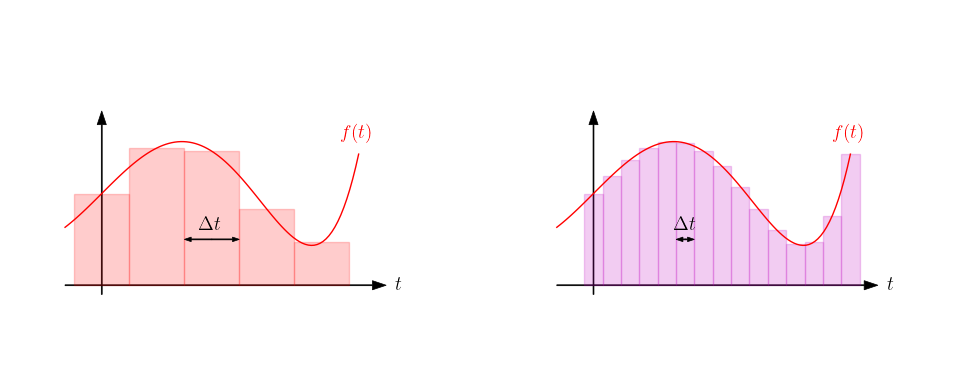

In [4]:
from matplotlib.patches import Rectangle, Arc

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax0.arrow(-0.4,0,3.5,0,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)
ax0.text(3.2,-0.05 ,r'$t$',fontsize=14,color='k')
ax0.arrow(0,-0.1,0,2,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)

x = np.linspace(-0.4,2.8,100)
y=1+x-0.5*x**3+0.05*x**5
ax0.plot(x,y,'r',linewidth=1)
ax0.text(2.6,1.6 ,r'$f(t)$',fontsize=14,color='r')

ax0.set_xlim(-1,4)
ax0.set_aspect('equal')
ax0.axis('off')
ax0.set_ylim(-1,3)

k=5
for i in range(k):
    thisX=i*3/k
    thisY=1+thisX-0.5*thisX**3+0.05*thisX**5
    ax0.add_patch(Rectangle((thisX-3/(2*k), 0), 3/k, thisY,edgecolor='r',facecolor='r',alpha=0.2))
    if i==2:
        ax0.arrow(thisX,0.5,3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax0.arrow(thisX,0.5,-3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax0.text(thisX-3/(4*k),0.6 ,r'$\Delta t$',fontsize=14,color='k')

ax1.arrow(-0.4,0,3.5,0,width=0.01,length_includes_head=True,head_width=0.1,
          overhang=0,color='k',linewidth=0.5)
ax1.text(3.2,-0.05 ,r'$t$',fontsize=14,color='k')
ax1.arrow(0,-0.1,0,2,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)

x = np.linspace(-0.4,2.8,100)
y=1+x-0.5*x**3+0.05*x**5
ax1.plot(x,y,'r',linewidth=1)
ax1.text(2.6,1.6 ,r'$f(t)$',fontsize=14,color='r')

ax1.set_xlim(-1,4)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_ylim(-1,3)

k=15
for i in range(k):
    thisX=i*3/k
    thisY=1+thisX-0.5*thisX**3+0.05*thisX**5
    ax1.add_patch(Rectangle((thisX-3/(2*k), 0), 3/k, thisY,edgecolor='m',facecolor='m',alpha=0.2))
    if i==5:
        ax1.arrow(thisX,0.5,3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax1.arrow(thisX,0.5,-3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax1.text(thisX-4/(2*k),0.6 ,r'$\Delta t$',fontsize=14,color='k')

fig.tight_layout()
fig.savefig(str(savedir / 'ch_LinSys_PulseApprox.pdf'), dpi=600, format='pdf', bbox_inches='tight');

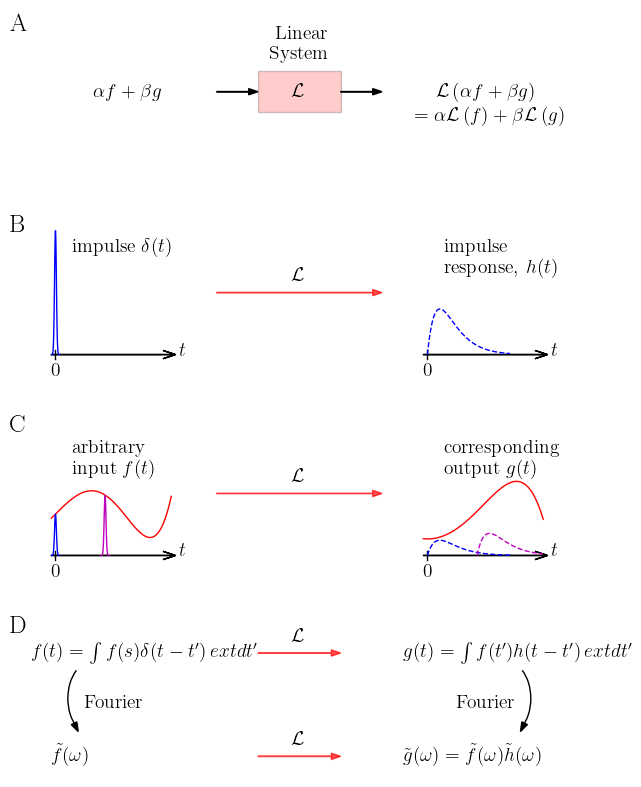

In [3]:
from matplotlib.patches import Rectangle, Arc

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(8,10))

ax0.text(2,1.9 ,r'$\alpha f + \beta g$',fontsize=14,color='k')

ax0.text(0,3.5,r'A',fontsize=18,color='k')
ax0.arrow(5,2,1,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax0.add_patch(Rectangle((6, 1.5), 2, 1,edgecolor='k',facecolor='r',alpha=0.2))
ax0.arrow(8,2,1,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax0.text(6.4,3.3 ,r'Linear',fontsize=14,color='k')
ax0.text(6.3,2.8 ,r'System',fontsize=14,color='k')
ax0.text(6.8,1.9 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax0.text(10.3,1.9 ,r'$\mathcal{L}\left( \alpha f + \beta g\right)$',fontsize=14,color='k')
ax0.text(9.8,1.3 ,r'$= \alpha\mathcal{L}\left(f\right) + \beta\mathcal{L}\left( g\right)$',fontsize=14,color='k')

ax0.set_xlim(0,15)
ax0.set_aspect('equal')
ax0.axis('off')
ax0.set_ylim(0,4)

ax1.text(0,3.5,r'B',fontsize=18,color='k')
ax1.arrow(5,2,4,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax1.text(6.8,2.3 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax1.arrow(1,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax1.text(4.1,0.5 ,r'$t$',fontsize=14,color='k')
ax1.arrow(10,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax1.text(13.1,0.5 ,r'$t$',fontsize=14,color='k')
ax1.plot([1.1,1.1],[0.4,0.6],'k',linewidth=1)
ax1.text(1.0,0 ,r'$0$',fontsize=14,color='k')
ax1.plot([10.1,10.1],[0.4,0.6],'k',linewidth=1)
ax1.text(10.0,0 ,r'$0$',fontsize=14,color='k')

x = np.linspace(-0.1,0.1,100)
y=3*np.exp(-x**2/0.001)
ax1.plot(x+1.1,y+0.5,'b',linewidth=1)
ax1.text(1.5,3 ,'impulse $\delta(t)$',fontsize=14,color='k')

x = np.linspace(0,2,100)
y=10*np.exp(-x/0.3)*x
ax1.plot(x+10.1,y+0.5,'b',linewidth=1,linestyle='dashed')
ax1.text(10.5,3 ,'impulse',fontsize=14,color='k')
ax1.text(10.5,2.5 ,'response, $h(t)$',fontsize=14,color='k')

ax1.set_xlim(0,15)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_ylim(0,4)


ax2.text(0,3.5,r'C',fontsize=18,color='k')
ax2.arrow(5,2,4,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax2.text(6.8,2.3 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax2.arrow(1,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax2.text(4.1,0.5 ,r'$t$',fontsize=14,color='k')
ax2.arrow(10,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax2.text(13.1,0.5 ,r'$t$',fontsize=14,color='k')
ax2.plot([1.1,1.1],[0.4,0.6],'k',linewidth=1)
ax2.text(1.0,0 ,r'$0$',fontsize=14,color='k')
ax2.plot([10.1,10.1],[0.4,0.6],'k',linewidth=1)
ax2.text(10.0,0 ,r'$0$',fontsize=14,color='k')

x = np.linspace(-0.1,2.8,100)
y=1+x-0.5*x**3+0.05*x**5
ax2.plot(x+1.1,y+0.5,'r',linewidth=1)
ax2.text(1.5,3 ,'arbitrary',fontsize=14,color='k')
ax2.text(1.5,2.5 ,'input $f(t)$',fontsize=14,color='k')

ax2.text(10.5,3 ,'corresponding',fontsize=14,color='k')
ax2.text(10.5,2.5 ,'output $g(t)$',fontsize=14,color='k')

x = np.linspace(-0.1,0.1,100)
y=1.0*np.exp(-x**2/0.001)
ax2.plot(x+1.1,y+0.5,'b',linewidth=1)
ax2.plot(x+2.3,1.45*y+0.5,'m',linewidth=1)

x = np.linspace(0,2,100)
y=10*np.exp(-x/0.3)*x
ax2.plot(x+10.1,y/3+0.5,'b',linewidth=1,linestyle='dashed')
ax2.plot(x[:80]+11.3,1.45*y[:80]/3+0.5,'m',linewidth=1,linestyle='dashed')

x = np.linspace(-0.1,2.8,100)
y=0.4+0.5*x**2-0.02*x**5
ax2.plot(x+10.1,(y+0.5),'r',linewidth=1)

ax2.set_xlim(0,15)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_ylim(0,4)


ax3.text(0.5,2.9 ,'$f(t)=\int f(s)\delta(t-t^\prime) \, {\mathrm{d}}t^\prime$',fontsize=14,color='k')
ax3.text(1,0.4 ,'$\\tilde{f}(\omega)$',fontsize=14,color='k')
ax3.text(9.5,2.9 ,'$g(t)=\int f(t^\prime) h(t-t^\prime) \, {\mathrm{d}}t^\prime$',fontsize=14,color='k')
ax3.text(9.5,0.4 ,'$\\tilde{g}(\omega)=\\tilde{f}(\omega)\\tilde{h}(\omega)$',fontsize=14,color='k')
ax3.text(0,3.5,r'D',fontsize=18,color='k')
ax3.arrow(6,0.5,2,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax3.arrow(6,3,2,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax3.text(6.8,3.3 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax3.text(6.8,0.8 ,r'$\mathcal{L}$',fontsize=14,color='k')

ax3.add_patch(Arc((2,1.9), 1.2, 1.8, angle=0.0, theta1=120, theta2=240,edgecolor='k'))
ax3.arrow(1.55,1.3,0.1,-0.20,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax3.text(1.8,1.7 ,'Fourier',fontsize=14,color='k')

ax3.add_patch(Arc((12,1.9), 1.2, 1.8, angle=0.0, theta1=300, theta2=60,edgecolor='k'))
ax3.arrow(12.45,1.3,-0.1,-0.20,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax3.text(10.8,1.7 ,'Fourier',fontsize=14,color='k')

ax3.set_xlim(0,15)
ax3.set_aspect('equal')
ax3.axis('off')
ax3.set_ylim(0,4)

#fig.tight_layout()
fig.savefig(str(savedir / 'ch_LinSys_Concepts.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Fourier transforms

#### Examples of Fourier transforms

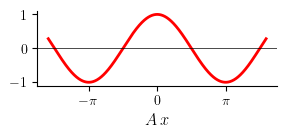

In [5]:
x = np.arange(-5, 5, 0.001)
y = np.cos(x)
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y, xlabel='$A \, x$', yzero=True, axes=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels(['$-\pi$', '$0$', '$\pi$'])
fig.savefig(str(savedir / 'ft_cos.pdf'), dpi=600, format='pdf', bbox_inches='tight');

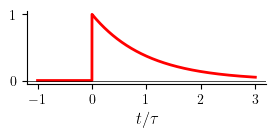

In [23]:
x = np.arange(-1, 3, 0.001)
y = np.exp(-x)
y[x<0]=0
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y,xlabel=r'$t / \tau$', yzero=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'ft_exp.pdf'), dpi=600, format='pdf', bbox_inches='tight');

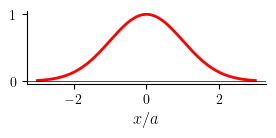

In [22]:
x = np.arange(-3, 3, 0.001)
y = np.exp(-x**2/2)
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y, xlabel='$x/a$', yzero=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'ft_gaussian.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### The power spectrum of a signal

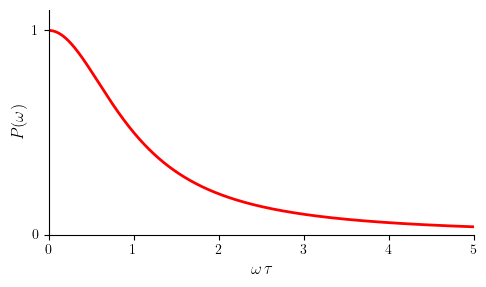

In [21]:
x = np.arange(0, 5, 0.001)
y = 1.0/(1+x**2)
fig, ax = plt.subplots(figsize=(5,3))
plot(x, y, xlabel=r'$\omega\,\tau$', xlim=(0,5), ylim=(0,1.1),
     ylabel=r'$P(\omega)$', yticks=[0,1], axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'power_spectrum.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### The Fourier Series

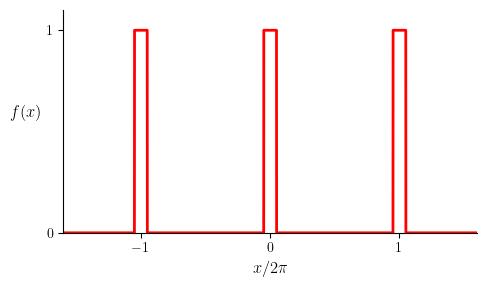

In [20]:
c = 0.314
x = np.arange(-1.6, 1.6, 0.001)
y = np.abs(x-np.round(x))<c/2/np.pi
fig, ax = plt.subplots(figsize=(5,3))
plot(x, y, xlabel=r'$x/2\pi$', xlim=(-1.6,1.6), ylim=(0,1.1),
     ylabel=r'$f(x)$', xticks=[-1,0,1], yticks=[0,1], yrot=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'img_per_pulse.pdf'), dpi=600, format='pdf', bbox_inches='tight');

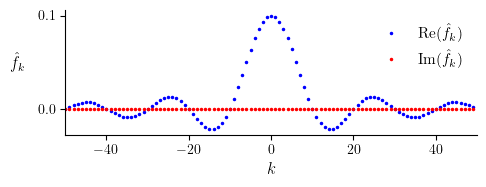

In [6]:
x = np.arange(-50.001, 49.999, 1) # to avoid the divide by zero
re = np.sin(x*c)/x/np.pi
im = x>100
fig, ax = plt.subplots(figsize=(5,2))
plot(x, [re,im], xlabel=r'$k$', ylabel=r'$\hat{f_k}$', yrot=True,
     xlim=(-50,50), yticks=[0,.1], markersize=3, fmts=['b.','r.'],
     legend=[r'$\mathrm{Re}(\hat{f_k})$',r'$\mathrm{Im}(\hat{f_k})$'], axes=ax);

ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'img_per_pulse_fs.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### The Discrete Fourier Transform

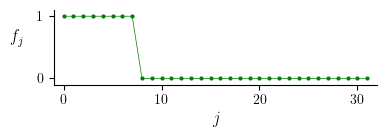

In [7]:
x = np.arange(0,32,1)
y = (x<8).astype(float)
fig, ax = plt.subplots(figsize=(4,1.5))
plot(x, y, xlabel=r'$j$', ylabel=r'$f_j$', yrot=True, xlim=(-1,32), ylim=(-.1,1.1),
     markersize=4, fmts=['g.-'], linewidth=0.5, yticks=[0,1], xticks=[0,10,20,30], axes=ax);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'img_dft_fj.pdf'), dpi=600, format='pdf', bbox_inches='tight');

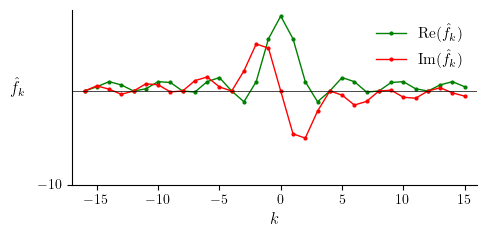

In [14]:
n = 32
m = 8
x = np.arange(-16+.001,16+.001,1) # to avoid singularity at 0
y = (1-np.exp(-2*np.pi*1j*x*m/n))/(1-np.exp(-2*np.pi*1j*x/n))
fig, ax = plt.subplots(figsize=(5,2.5))
legend=[r'$\mathrm{Re}(\hat{f}_k)$',r'$\mathrm{Im}(\hat{f}_k)$']
plot(x, [np.real(y),np.imag(y)], 
     xlabel=r'$k$', ylabel=r'$\hat{f}_k$', 
     xlim=(-17,16), markersize=4, fmts=['g.-','r.-'], linewidth=1, 
     yticks=[-10], yrot=True, yzero=True, axes=ax);
fig.tight_layout()
ax.legend(legend, loc='upper right')
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'img_dft_fk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

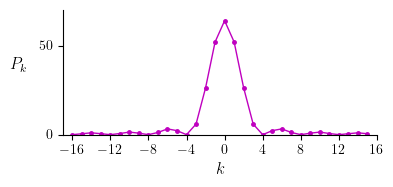

In [11]:
n = 32
m = 8
x = np.arange(-16+.001,16+.001,1) # to avoid singularity at 0
y = np.abs((1-np.exp(-2*np.pi*1j*x*m/n))/(1-np.exp(-2*np.pi*1j*x/n)))**2
fig, ax = plt.subplots(figsize=(4,2))
plot(x, y, xlabel=r'$k$', ylabel=r'$P_k$', 
          xlim=(-17,16), ylim=(0,70), markersize=5, fmts=['m.-'], linewidth=1, 
          yticks=[0,50], yrot=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(-16,20,4))
fig.savefig(str(savedir / 'img_dft_pk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

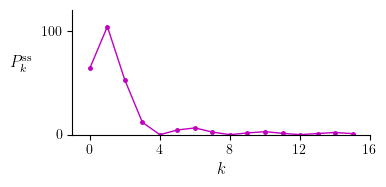

In [15]:
x1 = x[16:]
y1 = y[16:]*2
y1[0] /= 2
fig, ax = plt.subplots(figsize=(4,2))
plot(x1, y1, xlabel=r'$k$', ylabel=r'$P_k^{\text{ss}}$', 
    xlim=(-1,16), ylim=(0,120), markersize=5, fmts=['m.-'], linewidth=1, 
    xticks=list(range(0,20,4)), yticks=[0,100], yrot=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'img_dft_pssk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Applications

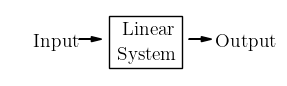

In [21]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc
fig,ax=plt.subplots(1,1,figsize=(3,1))
ax.text(-4 ,-0.2 ,r'Input',fontsize=14,color='k', rotation=0)
ax.text(4 ,-0.2 ,r'Output',fontsize=14,color='k', rotation=0)
ax.text(-0.1 ,0.5 ,r'Linear',fontsize=14,color='k', rotation=0)
ax.text(-0.3 ,-1 ,r'System',fontsize=14,color='k', rotation=0)
ax.add_patch(Rectangle((-0.7, -1.5), 3.2,3.1,edgecolor='k',fill=False))
ax.arrow(-2,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(2.8,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.axis('off')
ax.set_xlim([-5,5])
ax.set_ylim([-2,2])
fig.tight_layout()
fig.savefig(str(savedir / 'LinSys_schema1.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Microscopy

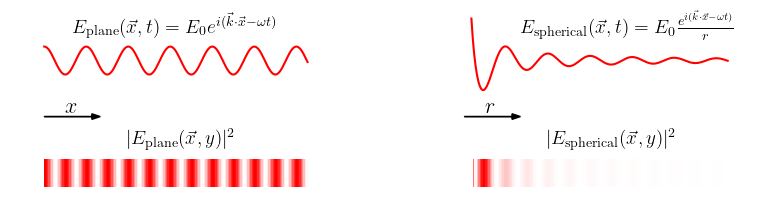

In [17]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc
import math

lam=3.0
k=2*np.pi/lam

x=np.arange(0,3*2*3.1415,0.1)
y=np.cos(k*x)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

axes.plot(x, y ,color='r')
axes.arrow(0,-4,4,0,width=0.001,length_includes_head=True,head_width=0.4,
                overhang=0,color='k')
axes.text(1.5,-3.7,r'$x$',fontsize=16,color='k')

for i in range(189):
    thisX=i/10
    axes.add_patch(Rectangle((thisX, -9),1/10, 2,facecolor='r',alpha=np.cos(k*thisX)**2))
    
axes.text(2,2,r'$E_{\text{plane}}(\vec{x},t)=E_0 e ^{i( \vec{k} \cdot \vec{x}-\omega t)}$',fontsize=14,color='k')
axes.text(6,-6,r'$\vert E_{\text{plane}}(\vec{x},y)\vert ^2$',fontsize=14,color='k')

rad=np.arange(0,3*2*3.1415,0.2)
  
axes.plot(x[5:]+30, 3*y[5:]/x[5:] ,color='r')
axes.text(34,2,r'$E_{\text{spherical}}(\vec{x},t)=E_0 \frac{e ^{i(\vec{k} \cdot \vec{x}-\omega t)}}{r}$',fontsize=14,color='k')
axes.text(36,-6,r'$\vert E_{\text{spherical}}(\vec{x},y)\vert ^2$',fontsize=14,color='k')
axes.arrow(30,-4,4,0,width=0.001,length_includes_head=True,head_width=0.4,
                overhang=0,color='k')
axes.text(31.5,-3.7,r'$r$',fontsize=16,color='k')

Amax=0.0
for i in range(189):
    if i>5:
        thisX=i/10
        this_alpha=(3*np.cos(k*thisX)/thisX)**2
        Amax=np.amax([Amax,this_alpha])
        
for i in range(189):
    if i>5:
        thisX=i/10
        this_alpha=(3*np.cos(k*thisX)/thisX)**2
        axes.add_patch(Rectangle((thisX+30, -9),1/10, 2,facecolor='r',alpha=this_alpha/Amax))
    
axes.axis('off')
axes.set_aspect('equal')

fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_PlaneWaves.pdf'), dpi=600, format='pdf', bbox_inches='tight');

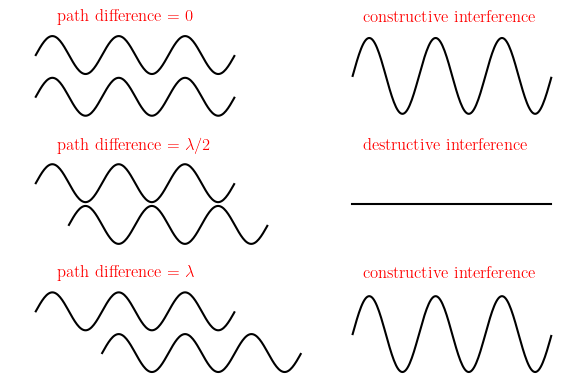

In [23]:
x=np.arange(0,3*2*3.1415,0.1)
y=np.sin(x)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,4))


axes[0].plot(x, y ,color='k')
axes[0].plot(x, y+2.2,color='k')
axes[0].plot(x+30, 2*y+1.1,color='k')
axes[0].xlim=(0,50)
axes[0].ylim=(-2,9)
axes[0].text(2,4,r'path difference = 0',fontsize=12,color='r')
axes[0].text(31,4,r'constructive interference',fontsize=12,color='r')
axes[0].axis('off')

axes[1].plot(x+3.1415, y ,color='k')
axes[1].plot(x, y+2.2,color='k')
axes[1].plot([30, 30+3*2*3.1415], [1.1,1.1],color='k')
axes[1].xlim=(0,50)
axes[1].ylim=(-2,9)
axes[1].text(2,4,r'path difference = $\lambda/2$',fontsize=12,color='r')
axes[1].text(31,4,r'destructive interference',fontsize=12,color='r')
axes[1].axis('off')

axes[2].plot(x+2*3.1415, y ,color='k')
axes[2].plot(x, y+2.2,color='k')
axes[2].plot(x+30, 2*y+1,color='k')
axes[2].xlim=(0,50)
axes[2].ylim=(-2,9)
axes[2].text(2,4,r'path difference = $\lambda$',fontsize=12,color='r')
axes[2].text(31,4,r'constructive interference',fontsize=12,color='r')
axes[2].axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_interference.pdf'), dpi=600, format='pdf', bbox_inches='tight');

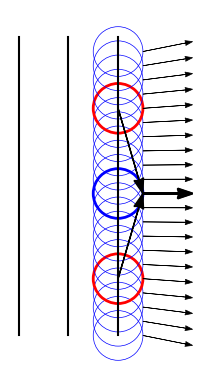

In [24]:

fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(4,4))

from matplotlib.patches import Rectangle, Circle, Wedge, Arc
from matplotlib.transforms import Bbox

for i in range(3):
    ax.plot([-i,-i],[0,6],'k')

for i in range(21):
        if i!=10:
            ax.add_patch(Circle((0, i*6/21),0.5,edgecolor='b',fill=False,linewidth=0.5))
        if i==10:
            ax.add_patch(Circle((0, i*6/21),0.5,edgecolor='b',fill=False,linewidth=2))
        if i==4 or i==16:
            ax.add_patch(Circle((0, i*6/21),0.5,edgecolor='r',fill=False,linewidth=2))    
ax.arrow(0,24/21,0.5,(60-24)/21,width=0.001,length_includes_head=True,head_width=0.2,overhang=0.1,color='k')
ax.arrow(0,16*6/21,0.5,(60-16*6)/21,width=0.001,length_includes_head=True,head_width=0.2,overhang=0.1,color='k')
ax.arrow(0.5,60/21,1,0,width=0.001,length_includes_head=True,head_width=0.2,overhang=0.1,color='k')
for i in range(21):
        if i!=10:
            ax.arrow(0.5,i*6/21,1,0.2*(i-10)*np.abs(i-10)/100,width=0.001,length_includes_head=True,head_width=0.1,overhang=0.1,color='k',linewidth=0.5)
        if i==10:
            ax.arrow(0.5,i*6/21,1,0,width=0.002,length_includes_head=True,head_width=0.2,overhang=0.1,color='k',linewidth=1.5)

#ax[1].add_patch(Rectangle((2, 0), 1.7, 3,color='0.8'))
#ax[1].plot([0.8,3.5],[1.85,1.85],color='k', linestyle='dashed', linewidth=1)
#ax[1].text(1.3,1.54 ,r'$\alpha$',fontsize=14,color='k') 
#ax[1].text(2.8,1.94 ,r'$\beta$',fontsize=14,color='k') 
#ax[1].arrow(2.7,0.6,0,-0.1,width=0.0001,length_includes_head=True,head_width=0.1,
#                overhang=0.1,color='k')

ax.axis('off')
ax.xlim=(-6,3)
ax.ylim=(0,6)

#ax[0].add_patch(Circle((2.92, 1.74),0.25,edgecolor='m',fill=False))
#ax[0].add_patch(Arc((1.76,1.65), 2*0.37, 2*0.37, angle=0.0, theta1=45, theta2=314.0,edgecolor='r'))

ax.set_aspect('equal')
fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_WaveProp.pdf'), dpi=600, format='pdf', bbox_inches='tight');

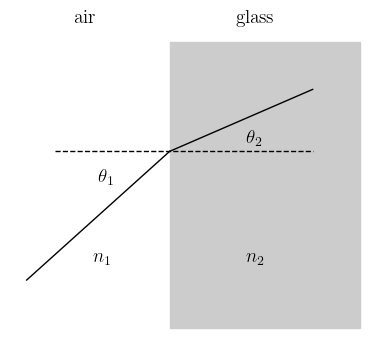

In [25]:
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(4,4))

from matplotlib.patches import Rectangle, Circle, Wedge, Arc
from matplotlib.transforms import Bbox

ax.add_patch(Rectangle((2, 0), 2, 3,color='0.8'))
ax.text(2.7,3.2 ,r'glass',fontsize=14,color='k') 
ax.text(1,3.2 ,r'air',fontsize=14,color='k') 
ax.plot([0.5,2],[0.5,1.85],color='k',  linewidth=1)
ax.plot([2,3.5],[1.85,2.5],color='k',  linewidth=1)
ax.plot([0.8,3.5],[1.85,1.85],color='k', linestyle='dashed', linewidth=1)
ax.text(1.25,1.54 ,r'$\theta_1$',fontsize=14,color='k') 
ax.text(2.8,1.94 ,r'$\theta_2$',fontsize=14,color='k') 
ax.text(1.2,0.7 ,r'$n_1$',fontsize=14,color='k') 
ax.text(2.8,0.7 ,r'$n_2$',fontsize=14,color='k') 
ax.set_aspect('equal')
ax.axis('off')
ax.xlim=(0,4)
ax.ylim=(0,4)
#ax.text(0.3,3.6 ,r'A',fontsize=18,color='k') 
fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_refraction1.pdf'), dpi=600, format='pdf', bbox_inches='tight');

/var/folders/yl/5q9cknc90hb_gxt6fwzjrl500000gn/T/ipykernel_25811/1035827702.py:47: RuntimeWarning: invalid value encountered in divide
  x = (np.sin(2*y)/y)*(np.sin(2*y)/y)


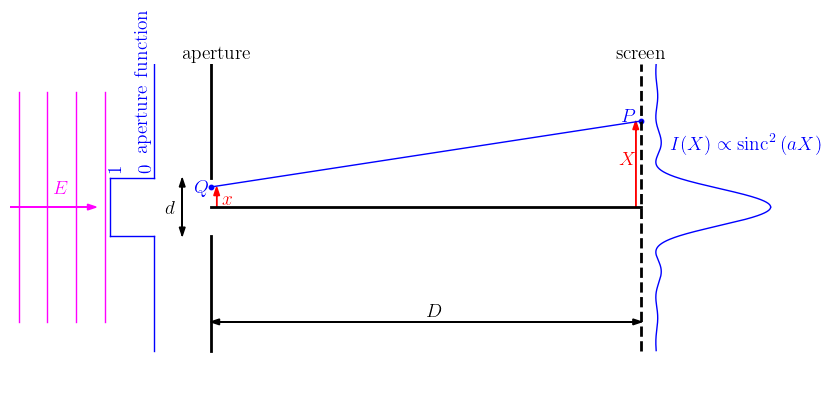

In [26]:
from matplotlib.patches import Wedge

fig,ax=plt.subplots(1,1,figsize=(10,5))

x=np.arange(-3,3.1,0.1)
y1=0.5-np.power(x,2)/18
y2=-0.5+np.power(x,2)/18

ax.plot([0,0],[-5,-1],linewidth=2,color='k')
ax.plot([0,0],[5,1],linewidth=2,color='k')
ax.arrow(-1,1,0,-2,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='k')
ax.arrow(-1,-1,0,2,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='k')
ax.arrow(0.2,0,0,0.7,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='r')
ax.text(0.4,0.1 ,r'$x$',fontsize=14,color='r') 
ax.text(-1.6,-0.2 ,r'$d$',fontsize=14,color='k') 
ax.plot([15,15],[-5,5],linewidth=2,color='k',linestyle='dashed')
ax.arrow(14.8,0,0,3,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='r')
ax.text(14.2,1.5 ,r'$X$',fontsize=14,color='r') 

ax.scatter(0,0.7,10,edgecolors='b',facecolors='b')
ax.text(-0.6,0.5 ,r'$Q$',fontsize=14,color='b') 
ax.scatter(15,3,10,edgecolors='b',facecolors='b')
ax.text(14.3,3 ,r'$P$',fontsize=14,color='b') 

ax.arrow(0,-4,15,0,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='k')
ax.arrow(15,-4,-15,0,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='k')
ax.text(7.5 ,-3.8 ,r'$D$',fontsize=14,color='k') 
ax.text(-1 ,5.2 ,r'aperture',fontsize=14,color='k') 
ax.text(14.1 ,5.2 ,r'screen',fontsize=14,color='k') 

ax.plot([0,15],[0,0],linewidth=2,color='k')

ax.plot([0,15],[0.7,3],linewidth=1,color='b')



for i in range(4):
    ax.plot([-6.7+i,-6.7+i],[-4,4],linewidth=1,color='magenta')
    
y = np.linspace(-5,5,1003)
x = (np.sin(2*y)/y)*(np.sin(2*y)/y)

ax.plot(x+15.5,y,linewidth=1,color='b')
ax.text(16 ,2 ,r'$I(X)\propto \text{sinc}^2\left( aX \right)$',fontsize=14,color='b') 



ax.plot([-2,-2],[-5,-1],linewidth=1,color='b')
ax.plot([-3.5,-2],[1,1],linewidth=1,color='b')
ax.plot([-3.5,-3.5],[-1,1],linewidth=1,color='b')
ax.plot([-2,-3.5],[-1,-1],linewidth=1,color='b')
ax.plot([-2,-2],[1,5],linewidth=1,color='b')

ax.arrow(-7,0,3,0,width=0.001,length_includes_head=True,head_width=0.2,
                overhang=0,color='magenta')
ax.text(-5.5 ,0.5 ,r'$E$',fontsize=14,color='magenta') 

ax.text(-2.7 ,2 ,r'aperture function',fontsize=14,color='b', rotation=90)
ax.text(-2.55 ,1.3 ,r'$0$',fontsize=14,color='b', rotation=90) 
ax.text(-3.6 ,1.3 ,r'$1$',fontsize=14,color='b', rotation=90) 

ax.axis('off')
ax.set_xlim([-7,20])
ax.set_ylim([-7,5])
ax.set_aspect('equal')
fig.savefig(str(savedir / 'ch_Micro_Fraunhofer1.pdf'), dpi=600, format='pdf', bbox_inches='tight');

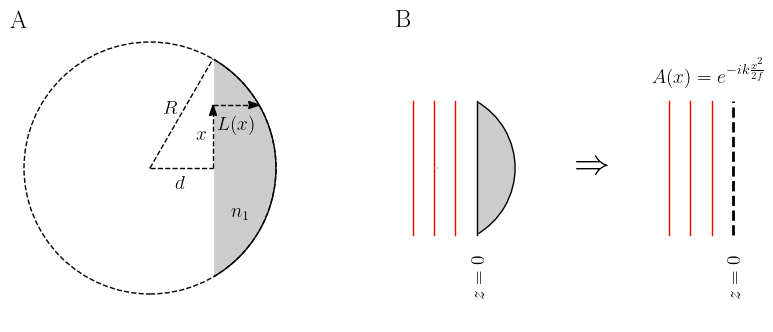

In [27]:
import math
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(10,4))

from matplotlib.patches import Rectangle, Circle, Wedge, Arc
from matplotlib.transforms import Bbox
 
ax[0].text(1.15,-0.7 ,r'$n_1$',fontsize=14,color='k') 
ax[0].text(0.18,0.77 ,r'$R$',fontsize=14,color='k') 
ax[0].text(0.35,-0.3 ,r'$d$',fontsize=14,color='k') 
ax[0].text(0.65,0.4 ,r'$x$',fontsize=14,color='k') 
ax[0].text(0.96,0.55 ,r'$L(x)$',fontsize=14,color='k') 
ax[0].add_patch(Wedge((0, 0),1.8,-60,60 ,edgecolor='k',facecolor='0.8',fill=True))
ax[0].add_patch(Rectangle((0, -2), 1.8*math.cos(math.pi/3),4,color='w',fill=True))
ax[0].add_patch(Circle((0, 0),1.8,edgecolor='k',fill=False,linestyle='dashed'))
ax[0].plot([0,1.8*math.cos(math.pi/3)],[0,1.8*math.sin(math.pi/3)],color='k',linestyle='dashed',  linewidth=1)
ax[0].plot([0,1.8*math.cos(math.pi/3)],[0,0],color='k',linestyle='dashed',  linewidth=1)
ax[0].plot([1.8*math.cos(math.pi/3),1.8*math.cos(math.pi/3)],[0,0.9],color='k',linestyle='dashed',  linewidth=1)
ax[0].plot([1.8*math.cos(math.pi/3),math.sqrt(1.8*1.8-0.9*0.9)],[0.9,0.9],color='k',linestyle='dashed',  linewidth=1)
ax[0].arrow(math.sqrt(1.8*1.8-0.9*0.9)-0.1,0.9,0.1,0,width=0.0001,length_includes_head=True,head_width=0.1,
                overhang=0.1,color='k')
ax[0].arrow(1.8*math.cos(math.pi/3),0.8,0,0.1,width=0.0001,length_includes_head=True,head_width=0.1,
                overhang=0.1,color='k')
ax[0].axis('off')
ax[0].xlim=(-2,2)
ax[0].ylim=(2,2)
ax[0].set_aspect('equal')
ax[0].text(-2,2 ,r'A',fontsize=18,color='k') 

ax[1].add_patch(Wedge((0, 0),1.8,-60,60 ,edgecolor='k',facecolor='0.8',fill=True))
ax[1].add_patch(Rectangle((0, -2), 1.8*math.cos(math.pi/3),4,color='w',fill=True))

ax[1].plot([1.8*math.cos(math.pi/3),1.8*math.cos(math.pi/3)],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='k',linewidth=1)
ax[1].plot([1.8*math.cos(math.pi/3)-1.5,1.8*math.cos(math.pi/3)-1.5],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='r',linewidth=1)
ax[1].plot([1.8*math.cos(math.pi/3)-1,1.8*math.cos(math.pi/3)-1],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='r',linewidth=1)
ax[1].plot([1.8*math.cos(math.pi/3)-0.5,1.8*math.cos(math.pi/3)-0.5],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='r',linewidth=1)

ax[1].plot([1.8*math.cos(math.pi/3)+6,1.8*math.cos(math.pi/3)+6],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='k',linewidth=2,linestyle='dashed')
ax[1].plot([1.8*math.cos(math.pi/3)+4.5,1.8*math.cos(math.pi/3)+4.5],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='r',linewidth=1)
ax[1].plot([1.8*math.cos(math.pi/3)+5,1.8*math.cos(math.pi/3)+5],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='r',linewidth=1)
ax[1].plot([1.8*math.cos(math.pi/3)+5.5,1.8*math.cos(math.pi/3)+5.5],[-1.8*math.sin(math.pi/3),1.8*math.sin(math.pi/3)],color='r',linewidth=1)
ax[1].text(5,2 ,r'$A(x)=e^{-ik\frac{x^2}{2f}}$',fontsize=14,color='k') 
ax[1].text(0.75,-3 ,r'$z=0$',fontsize=14,color='k',rotation=90) 
ax[1].text(0.75+6,-3 ,r'$z=0$',fontsize=14,color='k',rotation=90) 
ax[1].text(3.2,-0.3 ,r'$\Rightarrow$',fontsize=26,color='k') 

ax[1].axis('off')
ax[1].xlim=(-2,8)
ax[1].ylim=(2,2)
ax[1].set_aspect('equal')
ax[1].text(-1,3.3 ,r'B',fontsize=18,color='k')

fig.savefig(str(savedir / 'ch_Micro_LensAperture.pdf'), dpi=600, format='pdf', bbox_inches='tight');

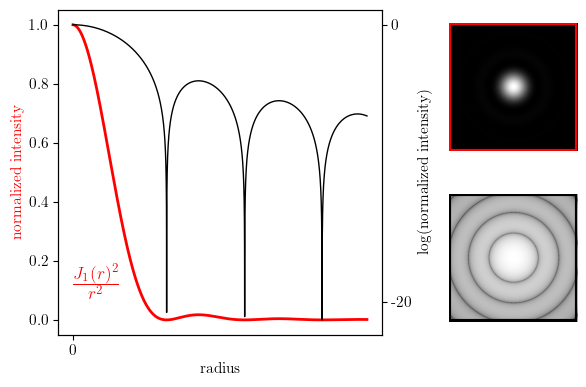

In [28]:
from scipy.special import jv

r = np.linspace(0.01,30,30000)
C=jv(1, r, out=None)

fig=plt.figure( figsize=(6,4))

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 2))

Y=(C/r)**2
Y=Y/max(Y)
ax1.plot(r[:12000],Y[:12000],'r',linewidth=2)
plt.yticks([0,1], ['0','1'])
ax11 = ax1.twinx()
ax1.set_ylabel(r'normalized intensity',color='r')
ax1.text(0,0.1,r'$\frac{J_1(r)^2}{r^2}$',fontsize=18,color='r')

ax1.set_xlabel(r'radius',color='k')
ax11.set_ylabel(r'log(normalized intensity)')
ax11.plot(r[:12000],np.log(Y[:12000]),'k',linewidth=1)
plt.yticks([-20,0], ['-20','0'])
plt.xticks([0], ['0'])  # Set text labels and properties.

Air=np.zeros((400,400))
Air2=np.zeros((400,400))
for i in range(400):
    for j in range(400):
        r=np.sqrt((i-200)**2+(j-200)**2)
        rs=r/20
        Air[i,j]=(Y[int(1000*(rs))])
        Air2[i,j]=np.log(Y[int(1000*(rs))])

ax2.add_patch(Rectangle((0, 0), 400, 400,edgecolor='r',fill=0,linewidth=3))
ax2.imshow(Air,cmap='gray')
ax2.axis('off')
ax3.add_patch(Rectangle((0, 0), 399, 399,edgecolor='k',fill=0,linewidth=3))
ax3.imshow(Air2,cmap='gray')
ax3.axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_AiryDisk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

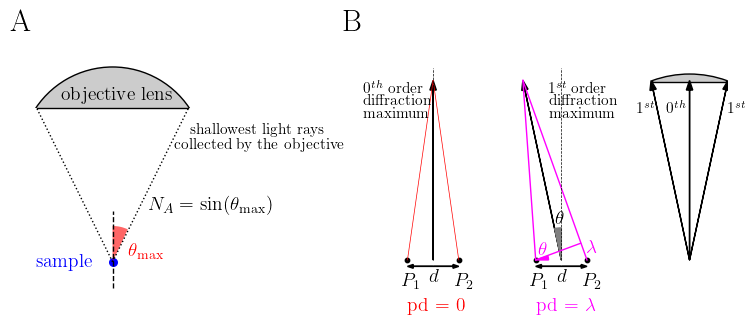

In [18]:
import math
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(9,4))

from matplotlib.patches import Rectangle, Circle, Wedge, Arc
  
ax.add_patch(Wedge((0, 0),1.8,30,150 ,edgecolor='k',facecolor='0.8',fill=True))
ax.add_patch(Rectangle((-2, -1),4,2,edgecolor='none',facecolor='w',fill=True))
ax.plot([-1.48,1.48],[1,1],'k',linewidth=1)
ax.scatter(0,-2,30,'b')
ax.plot([0,1.48],[-2,1],'k',linestyle='dotted',linewidth=1)
ax.plot([0,-1.48],[-2,1],'k',linestyle='dotted',linewidth=1)
ax.plot([0,-0],[-2.5,-1],'k',linestyle='dashed',linewidth=1)
ax.add_patch(Wedge((0, -2),0.7,65,90 ,edgecolor='none',facecolor='r',alpha=0.6,fill=True))
ax.text(0.3 ,-1.9 ,r'$\theta_{\text{max}}$',fontsize=14,color='r', rotation=0)
ax.text(-1 ,1.15 ,r'objective lens',fontsize=14,color='k', rotation=0)
ax.text(-1.5 ,-2.1 ,r'sample',fontsize=14,color='b', rotation=0)
ax.text(0.7 ,-1 ,r'$N_A=\sin(\theta_{\text{max}})$',fontsize=14,color='k', rotation=0)
ax.text(1.5 ,0.5 ,r'shallowest light rays',fontsize=11,color='k', rotation=0)
ax.text(1.2 ,0.2 ,r'collected by the objective',fontsize=11,color='k', rotation=0)



ax2 = ax.inset_axes([5, -2.5, 7, 4.5], transform = ax.transData)

ax2.add_patch(Wedge((25, 6),8.5,70,110 ,edgecolor='k',facecolor='0.8',fill=True))
ax2.add_patch(Rectangle((22, 5.9),6,8,edgecolor='none',facecolor='w',fill=True))
ax2.plot([22,28],[13.9,13.9],'k',linewidth=1)

ax2.arrow(25,0,0,14,width=0.001,length_includes_head=True,head_width=0.5,
                overhang=0,color='k')
ax2.arrow(25,0,3,14,width=0.001,length_includes_head=True,head_width=0.5,
                overhang=0,color='k')
ax2.arrow(25,0,-3,14,width=0.001,length_includes_head=True,head_width=0.5,
                overhang=0,color='k')

ax2.scatter(3,0,10,edgecolors='k',facecolors='k')
ax2.scatter(7,0,10,edgecolors='k',facecolors='k')
ax2.text(2.5,-2 ,r'$P_1$',fontsize=14,color='k') 
ax2.text(6.6,-2 ,r'$P_2$',fontsize=14,color='k')

ax2.plot([3,5],[0,14],linewidth=0.5,color='r')
ax2.plot([7,5],[0,14],linewidth=0.5,color='r')
ax2.plot([5,5],[0,15],linewidth=0.5,color='k',linestyle='dashed')
ax2.arrow(5,0,0,14,width=0.001,length_includes_head=True,head_width=0.5,
                overhang=0,color='k')

ax2.plot([13,12],[0,14],linewidth=1,color='magenta')
ax2.plot([17,12],[0,14],linewidth=1,color='magenta')
ax2.plot([15,15],[0,15],linewidth=0.5,color='k',linestyle='dashed')
ax2.plot([13,16.5],[0,1.3],linewidth=1,color='magenta')
#ax.arrow(5,0,0,14,width=0.001,length_includes_head=True,head_width=0.5,
#                overhang=0,color='k')
ax2.arrow(15,0,-3,14,width=0.001,length_includes_head=True,head_width=0.5,
                overhang=0,color='k')


ax2.scatter(13,0,10,edgecolors='k',facecolors='k')
ax2.scatter(17,0,10,edgecolors='k',facecolors='k')
ax2.text(12.5,-2 ,r'$P_1$',fontsize=14,color='k') 
ax2.text(16.6,-2 ,r'$P_2$',fontsize=14,color='k')

ax2.text(-0.5,13,r'$0^{th}$ order',fontsize=11,color='k')
ax2.text(-0.5,12,r'diffraction',fontsize=11,color='k')
ax2.text(-0.5,11,r'maximum',fontsize=11,color='k')

ax2.text(14,13,r'$1^{st}$ order',fontsize=11,color='k')
ax2.text(14,12,r'diffraction',fontsize=11,color='k')
ax2.text(14,11,r'maximum',fontsize=11,color='k')

ax2.text(23.2,11.5,r'$0^{th}$',fontsize=11,color='k')
ax2.text(20.9,11.5,r'$1^{st}$',fontsize=11,color='k')
ax2.text(28.,11.5,r'$1^{st}$',fontsize=11,color='k')



ax.text(-2,2.5,r'A',fontsize=22,color='k')
ax.text(4.5,2.5,r'B',fontsize=22,color='k')


ax2.text(14.5,2.8,r'$\theta$',fontsize=14,color='k')
ax2.text(13.2,0.4,r'$\theta$',fontsize=14,color='magenta')

ax2.add_patch(Wedge([15, 0], 2.5, 90, 102, fill=1, color='0.5'))
ax2.add_patch(Wedge([13, 0], 1., 0, 17, fill=1, color='magenta'))

ax2.arrow(5,-0.5,2,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax2.arrow(5,-0.5,-2,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')

ax2.arrow(15,-0.5,2,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax2.arrow(15,-0.5,-2,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')

ax2.text(4.7,-1.7,r'$d$',fontsize=14,color='k')
ax2.text(14.7,-1.7,r'$d$',fontsize=14,color='k')
ax2.text(17,0.5,r'$\lambda$',fontsize=14,color='magenta')


ax2.text(3,-4,r'pd = $0$',fontsize=14,color='red')
ax2.text(13,-4,r'pd = $\lambda$',fontsize=14,color='magenta')


ax2.axis('off')
ax2.set_xlim([0,28])
ax2.set_ylim([-1.3,15])
ax2.set_aspect('equal')

ax.axis('off')
ax.set_xlim([-1.6,12])
ax.set_ylim([-3,2])
ax.set_aspect('equal')

fig.savefig(str(savedir / 'NA.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Simple microscope

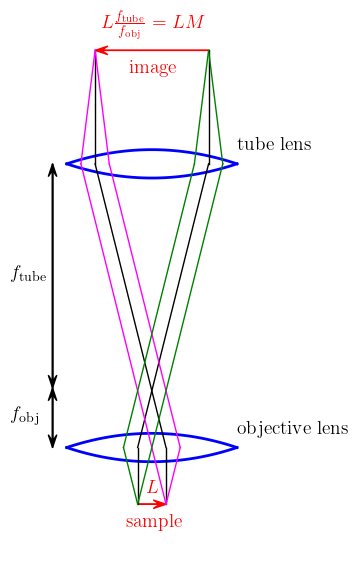

In [46]:
from matplotlib.patches import Rectangle

fig,ax=plt.subplots(1,1,figsize=(7,7))

x=np.arange(-3,3.1,0.1)
y1=0.5-np.power(x,2)/18
y2=-0.5+np.power(x,2)/18

ax.plot(x,y1,linewidth=2,color='b')
ax.plot(x,y2,linewidth=2,color='b')

x=np.arange(-3,3.1,0.1)
y1=0.5-np.power(x,2)/18+10
y2=-0.5+np.power(x,2)/18+10

ax.plot(x,y1,linewidth=2,color='b')
ax.plot(x,y2,linewidth=2,color='b')

ax.arrow(-0.5,-2,1,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='red')
ax.arrow(2,14,-4,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='red')
ax.arrow(-3.5,0,0,2.1,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(-3.5,10,0,-7.9,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(-3.5,2.1,0,-2.1,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(-3.5,2.1,0,7.9,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')

ax.plot([-0.5,-0.5],[-2,0],linewidth=1,color='k')
ax.plot([0.5,0.5],[-2,0],linewidth=1,color='k')
ax.plot([2,-0.5],[10,0],linewidth=1,color='k')
ax.plot([-2,0.5],[10,0],linewidth=1,color='k')
ax.plot([-2,-2],[10,14],linewidth=1,color='k')
ax.plot([2,2],[10,14],linewidth=1,color='k')

ax.plot([0.5,-2.5],[-2,10],linewidth=1,color='magenta')
ax.plot([-2.5,-2],[10,14],linewidth=1,color='magenta')
ax.plot([0.5,1],[-2,0],linewidth=1,color='magenta')
ax.plot([1,-1.5],[0,10],linewidth=1,color='magenta')
ax.plot([-1.5,-2],[10,14],linewidth=1,color='magenta')

ax.plot([-0.5,2.5],[-2,10],linewidth=1,color='g')
ax.plot([2.5,2],[10,14],linewidth=1,color='g')
ax.plot([-0.5,-1],[-2,0],linewidth=1,color='g')
ax.plot([-1,1.5],[0,10],linewidth=1,color='g')
plt.plot([1.5,2],[10,14],linewidth=1,color='g')


ax.text(3,10.5,r'tube lens',fontsize=14)
ax.text(3,0.5,r'objective lens',fontsize=14)
ax.text(-1.8,14.8 ,r'$L \frac{f_{\text{tube}}}{f_\text{obj}} = LM$',fontsize=14,color='r')
ax.text(-0.2,-1.6 ,r'$L $',fontsize=14,color='r')
ax.text(-0.9,-2.8 ,r'sample',fontsize=14,color='r')
ax.text(-0.8,13.2 ,r'image',fontsize=14,color='r')
ax.text(-5,6 ,r'$f_{\text{tube}}$',fontsize=14,color='k')
ax.text(-5,1 ,r'$f_{\text{obj}} $',fontsize=14,color='k')

ax.axis('off')
ax.set_xlim([-4,5])
ax.set_ylim([-4,15])
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot([-5,-10],[-5,-10],linewidth=2,color='b', alpha=0.5)
ax.plot([-5,-10],[-5,-10],linewidth=2,color='k')

ax.add_patch(Rectangle((-0.3, -0.4), 1, 0.6,color="white"))
fig.savefig(str(savedir / 'ch_Micro_simplescope.pdf'), dpi=600, format='pdf', bbox_inches='tight');

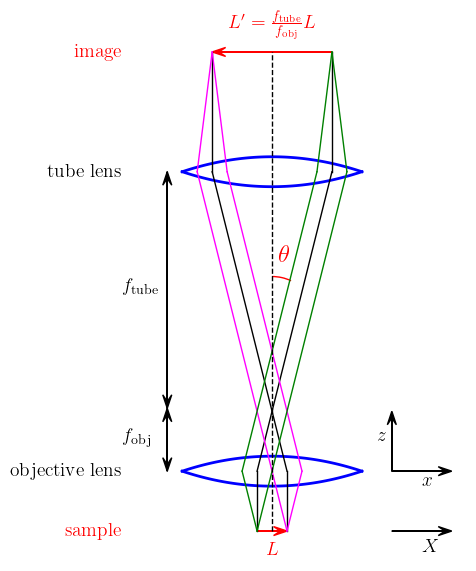

In [132]:
# revised MM 231105
from matplotlib.patches import Rectangle
from matplotlib.patches import Arc

fig,ax=plt.subplots(1,1,figsize=(7,7))

# lenses
x=np.arange(-3,3.1,0.1)
y1=0.5-np.power(x,2)/18
y2=-0.5+np.power(x,2)/18
ax.plot(x,y1,linewidth=2,color='b')
ax.plot(x,y2,linewidth=2,color='b')
ax.plot(x,y1+10,linewidth=2,color='b')
ax.plot(x,y2+10,linewidth=2,color='b')

# sample and image
ax.arrow(-0.5,-2,1,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='red')
ax.arrow(2,14,-4,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='red')

# arrows on side
ax.arrow(-3.5,0,0,2.1,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(-3.5,2.1,0,-2.1,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(-3.5,10,0,-7.9,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(-3.5,2.1,0,7.9,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')

# rays
ax.plot([-0.5,-0.5],[-2,0],linewidth=1,color='k')
ax.plot([0.5,0.5],[-2,0],linewidth=1,color='k')
ax.plot([2,-0.5],[10,0],linewidth=1,color='k')
ax.plot([-2,0.5],[10,0],linewidth=1,color='k')
ax.plot([-2,-2],[10,14],linewidth=1,color='k')
ax.plot([2,2],[10,14],linewidth=1,color='k')

ax.plot([0.5,-2.5],[-2,10],linewidth=1,color='magenta')
ax.plot([-2.5,-2],[10,14],linewidth=1,color='magenta')
ax.plot([0.5,1],[-2,0],linewidth=1,color='magenta')
ax.plot([1,-1.5],[0,10],linewidth=1,color='magenta')
ax.plot([-1.5,-2],[10,14],linewidth=1,color='magenta')

ax.plot([-0.5,2.5],[-2,10],linewidth=1,color='g')
ax.plot([2.5,2],[10,14],linewidth=1,color='g')
ax.plot([-0.5,-1],[-2,0],linewidth=1,color='g')
ax.plot([-1,1.5],[0,10],linewidth=1,color='g')
ax.plot([1.5,2],[10,14],linewidth=1,color='g')

# optical axis
ax.plot([0,0],[-2,14],linewidth=1,color='k',linestyle='dashed')

# text labels
ax.text(-5,10,r'tube lens',fontsize=14,ha='right',va='center')
ax.text(-5,0,r'objective lens',fontsize=14,ha='right',va='center')
ax.text(0,14.8 ,r"$L' = \frac{f_{\text{tube}}}{f_\text{obj}} L$",fontsize=14,color='r',ha='center')
ax.text(-0,-2.8 ,r'$L$',fontsize=14,color='r',ha='center')
ax.text(-5,-2 ,r'sample',fontsize=14,color='r',ha='right',va='center')
ax.text(-5,14 ,r'image',fontsize=14,color='r',ha='right',va='center')
ax.text(-5,6 ,r'$f_{\text{tube}}$',fontsize=14,color='k')
ax.text(-5,1 ,r'$f_{\text{obj}} $',fontsize=14,color='k')

# angle theta
ax.add_patch(Arc((0,5), 3, 3, angle=90, theta1=-25, theta2=0, linewidth=1, color='red')) # draw arc
ax.text(0.2,7,r'$\theta$',fontsize=18,color='r')

# coordinates
ax.arrow(4,-2,2,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.text(5,-2.7,r'$X$',fontsize=14,color='k')
ax.arrow(4,0,2,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.text(5,-0.5,r'$x$',fontsize=14,color='k')
ax.arrow(4,0,0,2,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.text(3.5,1,r'$z$',fontsize=14,color='k')
# ax.arrow(6,14,-2,0,width=0.001,length_includes_head=True,head_width=0.3,
#                 overhang=0.5,color='black')
# ax.text(4.7,13.3,r"$x'$",fontsize=14,color='k')
  
ax.axis('off')
ax.set_xlim([-4,6.5])
ax.set_ylim([-3,15])
ax.set_aspect('equal')

fig.savefig(str(savedir / 'ch_Micro_simplescope_MM.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Diffraction at aperture

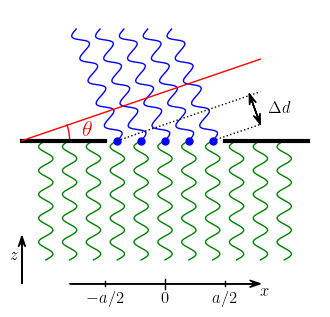

In [128]:
from matplotlib.patches import Rectangle
from matplotlib.patches import Arc
from matplotlib import transforms as mpltransforms

fig,ax=plt.subplots(1,1,figsize=(4,4))

x=np.arange(0,5,0.01)
y=np.sin(x*2*np.pi)
for h in np.arange(-5,6,1):
    ax.plot(0.3*y+h,x-5,linewidth=1,color='g')
ax.plot([-6,-2.5],[0,0],linewidth=3,color='k')
ax.plot([2.5,6],[0,0],linewidth=3,color='k')
ax.plot([-2,-1,0,1,2],[0,0,0,0,0],linewidth=0,color='b',marker='o',markersize=5)

th=20 # angle in degrees
for h in np.arange(-2,3,1):
    ax.plot(0.3*y+h,x,linewidth=1,color='b', transform=mpltransforms.Affine2D().rotate_deg_around(h,0,th)+ax.transData)
ax.plot([-6,4],[0,10*np.sin(th*np.pi/180)],linewidth=1,color='r')
ax.add_patch(Arc((-6,0), 4, 4, angle=0, theta1=0, theta2=th, linewidth=1, color='r')) # draw arc
ax.text(-3.5,0.2,r'$\theta$',fontsize=16,color='r')

ax.arrow(-4,-6,8,0,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.text(4,-6.5,r'$x$',fontsize=12,color='k')
ax.plot([0,0],[-6.2,-5.8],linewidth=1,color='k')
ax.plot([-2.5,-2.5],[-6.1,-5.9],linewidth=1,color='k')
ax.plot([2.5,2.5],[-6.1,-5.9],linewidth=1,color='k')
ax.text(0,-6.8,r'$0$',fontsize=12,color='k',ha='center')
ax.text(2.5,-6.8,r'$a/2$',fontsize=12,color='k',ha='center')
ax.text(-2.5,-6.8,r'$-a/2$',fontsize=12,color='k',ha='center')

ax.arrow(-6,-6,0,2,width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.text(-6.5,-5,r'$z$',fontsize=12,color='k')

ax.plot([2,4],[0,2*np.sin(th*np.pi/180)],linewidth=1,color='k',linestyle=':')
ax.plot([-2,4],[0,6*np.sin(th*np.pi/180)],linewidth=1,color='k',linestyle=':')
ax.arrow(4,2*np.sin(th*np.pi/180),-4*np.sin(th*np.pi/180)*np.sin(th*np.pi/180),4*np.sin(th*np.pi/180)*np.cos(th*np.pi/180),width=0.001,length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.arrow(4-4*np.sin(th*np.pi/180)*np.sin(th*np.pi/180),2*np.sin(th*np.pi/180)+4*np.sin(th*np.pi/180)*np.cos(th*np.pi/180),4*np.sin(th*np.pi/180)*np.sin(th*np.pi/180),-4*np.sin(th*np.pi/180)*np.cos(th*np.pi/180),width=0.001,     length_includes_head=True,head_width=0.3,
                overhang=0.5,color='black')
ax.text(4.3,1.2,r'$\Delta d$',fontsize=12,color='k')





ax.set_aspect('equal')
ax.set_xlim([-6.5,6.5])
ax.set_ylim([-6.5,5.5])
ax.axis('off')

fig.savefig(str(savedir / 'ch_aperture_MM.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Airy disc

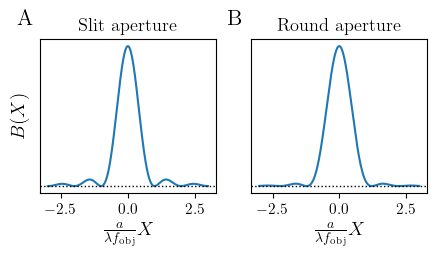

In [21]:
from scipy.special import jv

r = np.linspace(0.01,30,30000)
C=jv(1, r, out=None)

fig,ax=plt.subplots(1,2,figsize=(5,2))
x=np.arange(-3,3.02,0.02)
x[len(x)//2]=0.0001 # to avoid division by zero
y=(np.sin(np.pi*x)/(np.pi*x))**2
ax[0].plot(x,y)
ax[0].axhline(y=0, linestyle=':', color='k',linewidth=1) # add a dotted line at y=0
ax[0].set_xlabel(r'$\frac{a}{\lambda f_{\text{obj}}} X $', fontsize=14)
ax[0].set_ylabel(r'$B(t)$', fontsize=14)
ax[0].set_yticks([])
ax[0].set_yticklabels([])
ax[0].set_title('Slit aperture')
z=(jv(1,np.pi*x)/(np.pi*x))**2
ax[1].plot(x,z)
ax[1].axhline(y=0, linestyle=':', color='k',linewidth=1) # add a dotted line at y=0
ax[1].set_xlabel(r'$\frac{a}{\lambda f_{\text{obj}}} X $', fontsize=14)
# ax[1].set_ylabel(r'$B(X)$', fontsize=14)
ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].set_title('Round aperture')

fig.text(0.08, 0.95, "A", fontsize=16, fontweight="bold")
fig.text(0.5, 0.95, "B", fontsize=16, fontweight="bold")

fig.savefig(str(savedir / 'Blur_Profile.pdf'), dpi=600, format='pdf', bbox_inches='tight')


### Microscopy as a convolution

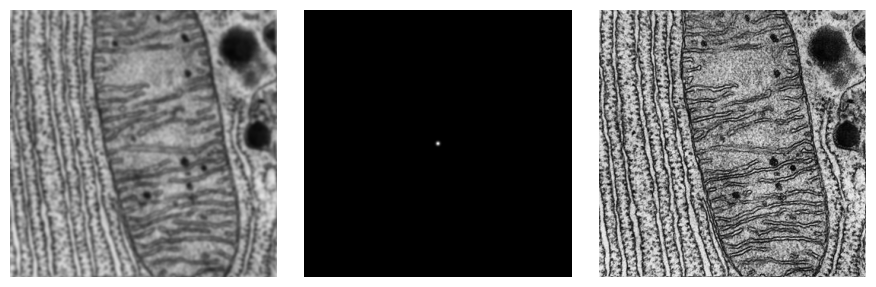

In [29]:
import matplotlib.image as mpimg
from scipy import fftpack

im2 = mpimg.imread(str(datadir / 'mito.tif'))
im=im2[100:451,0:351]
im=im/255

psf=np.zeros([351,351])
for i in range(psf.shape[0]):
    for j in range(psf.shape[1]):
        X=np.exp(-((i-175)*(i-175)+(j-175)*(j-175))/(6))
        psf[i,j]=X
psf=psf/np.sum(psf)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,3))

def convolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

im_conv = convolve(im, psf)
im_deconv = deconvolve(im_conv, psf)

#axes[0,2].imshow(im)
axes[0].imshow(np.real(im_conv),cmap='gray', vmin=0, vmax=1)
axes[1].imshow(np.real(psf),cmap='gray')
axes[2].imshow(np.real(im_deconv),cmap='gray', vmin=0, vmax=1)

for i in range(3):
    axes[i].axis('off')
    axes[i].set_aspect('equal')
fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_decon1.pdf'), dpi=600, format='pdf', bbox_inches='tight');

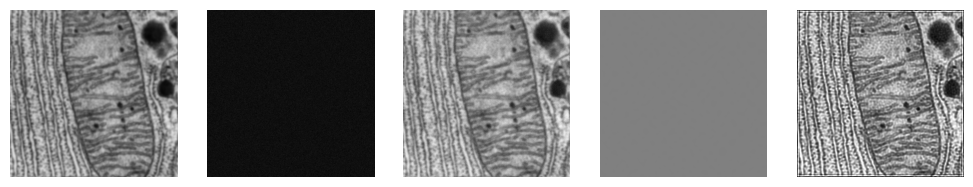

In [30]:
import matplotlib.image as mpimg
from scipy import fftpack
from skimage import restoration

im2 = mpimg.imread(str(datadir / 'mito.tif'))
im=im2[100:451,0:351]
im=im/255

psf=np.zeros([351,351])
for i in range(psf.shape[0]):
    for j in range(psf.shape[1]):
        X=np.exp(-((i-175)*(i-175)+(j-175)*(j-175))/(6))
        psf[i,j]=X
psf=psf/np.sum(psf)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10,2))

def convolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

im_conv = convolve(im, psf)
im_deconv = deconvolve(im_conv, psf)

#axes[0,2].imshow(im)


im_noisy=np.copy(np.real(im_conv))
noise=(np.random.poisson(lam=25, size=im.shape) - 10) / 255.
im_noisy=im_noisy+noise
        
im_noisy_deconv = deconvolve(im_noisy, psf)

axes[0].imshow(np.real(im_conv),cmap='gray', vmin=0, vmax=1)
axes[1].imshow(noise,cmap='gray', vmin=0, vmax=1)
axes[2].imshow(im_noisy,cmap='gray', vmin=0, vmax=1)
axes[3].imshow(np.real(im_noisy_deconv),cmap='gray')

deconvolved_RL = restoration.richardson_lucy(np.real(im_noisy), psf, num_iter=30)
axes[4].imshow(deconvolved_RL,cmap='gray', vmin=0, vmax=1)

for i in range(5):
    axes[i].axis('off')
    axes[i].set_aspect('equal')
fig.tight_layout()
fig.savefig(str(savedir / 'ch_Micro_decon2.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Deconvolution microscopy

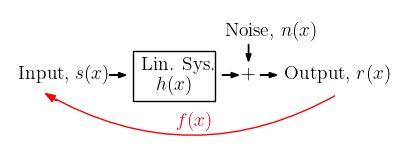

In [31]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(4.2,1.7))
ax.text(-7.5 ,-0.05 ,r'Input, $s(x)$',fontsize=14,color='k', rotation=0)
ax.text(8.6 ,-0.05 ,r'Output, $r(x)$',fontsize=14,color='k', rotation=0)
ax.text(-0.1 ,0.5 ,r'Lin. Sys.',fontsize=14,color='k', rotation=0)
ax.text(0.9 ,-0.7 ,r'$h(x)$',fontsize=14,color='k', rotation=0)
ax.add_patch(Rectangle((-0.6, -1.3), 5,2.9,edgecolor='k',fill=False))
ax.arrow(-2,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(4.8,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(7.1,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(6.4,2,0,-1,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.text(6 ,-0.05 ,r'$+$',fontsize=14,color='k', rotation=0)
ax.text(5 ,2.5 ,r'Noise, $n(x)$',fontsize=14,color='k', rotation=0)
ax.axis('off')

ax.add_patch(patches.FancyArrowPatch(posA=(12, -0.8), posB=(-6, -0.8), connectionstyle="angle3,angleA=30,angleB=150",
                                          lw=1, arrowstyle=u'|-|', color='r',
                                          mutation_scale=5))
ax.add_patch(patches.Rectangle((11.6,-1.4), 1, 1, angle=0.0, facecolor='w',alpha=1,zorder=1))
ax.add_patch(patches.Rectangle((-6.2,-1.4), 1, 1, angle=0.0, facecolor='w',alpha=1,zorder=1))
ax.arrow(-5.15,-1.3,-0.2,0.12,width=0.01,head_width=0.4,overhang=0,color='r',zorder=2)
ax.text(2 ,-2.8 ,r'$f(x)$',fontsize=14,color='r', rotation=0)

ax.set_xlim([-8,13])
ax.set_ylim([-4,4])
fig.tight_layout()
fig.savefig(str(savedir / 'LinSys_schema2.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Deconvolution light microscopy
Downloaded some images using PALM/STORM compared to regular microscopy:
- img1 from https://zeiss-campus.magnet.fsu.edu/articles/superresolution/palm/practicalaspects.html, no scale bar
- img2 from https://www.cup.uni-muenchen.de/pc/lamb/techniques/storm_palm.html
- img 3 from https://www.ohsu.edu/school-of-medicine/nan-lab/research. 2 um = 53 pixels
- img4 from https://pubs.acs.org/doi/epdf/10.1021/acs.joc.8b00756
  

img4 scale: 
1 um = 33 pixels

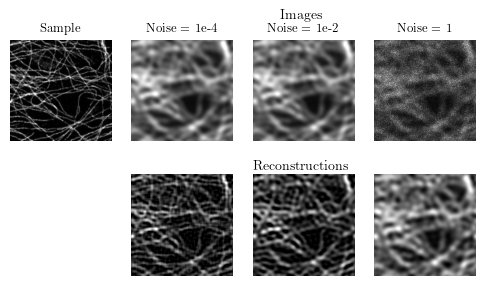

In [124]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft2, ifft2
from skimage import color
from scipy.special import jv

um = 53/2 # pixels per micron
ar = 0.2 * um # radius of Airy disk
no = 0.0001
sn = 1e8 # signal-to-noise ratio assumed for Wiener deconvolution

# Load the image
# img = plt.imread('Deconvolution/img3-10x10um.jpg')
img = plt.imread('Deconvolution/img4-10x10um.jpg')

# Convert the image to grayscale
img = color.rgb2gray(img)

# Compute the x- and y-coordinates for the image
x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))

# Origin in the middle of the image
yo, xo = np.array(img.shape) // 2

# Make the Airy disk kernel
r=np.sqrt((x-xo)**2+(y-yo)**2) # radius from origin
r[r==0]=1e-6 # avoids divide by zero
ker_shift = (jv(1, r/ar) / r) ** 2
ker = np.roll(np.roll(ker_shift, -yo, axis=0), -xo, axis=1) # put origin of kernel at (0,0)

# Make blurred image
blu = ifft2(fft2(img)*fft2(ker)).real # blurred image; don't worry about edge effects, use circular convolution

# compute deconvolution
N=[]; W=[]
for no in [0, 1e-4, 1e-2, 1]: # noise values
    sn = 1 / (no+1e-8)**2 # adjust the wiener filter's snr to the noise
    
    # Add noise
    noi = blu + np.maximum(no * np.sqrt(blu) * np.random.normal(size=blu.shape),0) # add noise prop to square root, clip to zero
    N+=[noi]

    # Wiener deconvolution: assume both stimulus and noise spectra are white, with power ratio = sn
    wie = (fft2(ker).conjugate() * sn)/(np.abs(fft2(ker))**2 * sn + 1) # wiener kernel fourier transform
    dew = ifft2(wie * fft2(noi)).real # wiener filtered image
    W+=[dew]
    
fig, ax = plt.subplots(2, 4, figsize=(6, 3.2))
arr=[img, N[1], N[2], N[3]]
tit=[f'Sample','Noise = 1e-4','Noise = 1e-2','Noise = 1']
vmax=[0.9, 0.9, 0.9, 0.5] # scale of intensity axis
for i in range(4):
    ax[0,i].imshow(arr[i], cmap='gray', vmin=0, vmax=vmax[i]*np.max(arr[i]))
    ax[0,i].set_title(tit[i], fontsize=9)
    ax[0,i].axis('off')
arr=[ker, W[1], W[2], W[3]]
tit=['Kernel','Wiener, N = 1e-4','Wiener, N = 1e-2','Wiener, N = 1']
vmax=[0.9, 0.9, 0.9, 0.9]
ax[1,0].axis('off')
for i in range(1,4):
    ax[1,i].imshow(arr[i], cmap='gray', vmin=0, vmax=vmax[i]*np.max(arr[i]))
    ax[1,i].axis('off')
fig.text(0.61,0.92,'Images',fontsize=10, ha = 'center', va = 'bottom')
fig.text(0.61,0.45,'Reconstructions',fontsize=10, ha = 'center', va = 'bottom')
plt.show()
fig.savefig(str(savedir / 'micro-decon.pdf'), dpi=600, format='pdf', bbox_inches='tight');   


### Crystal lattice

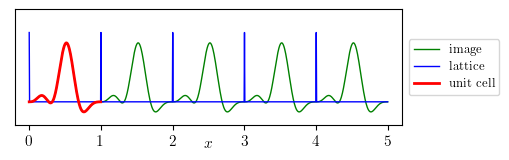

In [61]:
# diagram of a lattice and unit cell

fig,ax=plt.subplots(1,1,figsize=(5,1.5))

# create unit cell
x = np.linspace(0,1,200,endpoint=False)
k=np.pi
u=np.sin(k*x)+0.5*np.sin(2*k*x)-0.8*np.sin(3*k*x)+0.7*np.sin(4*k*x)+0.7*np.sin(5*k*x)
u*=np.sin(k*x)**2

# create lattice
x1=np.linspace(0,5,1000,endpoint=False)
l=np.zeros(1000)
l[0::200]=1

# create the image
i = np.tile(u, 5)

# plot
ax.plot(x1,i,color='g',linewidth=1)
ax.plot(x1,l*3,color='b',linewidth=1)
ax.plot(x,u,color='r',linewidth=2)

# adjust the plot
ax.set_yticks([])
ax.set_xlabel(r'$x$')
ax.xaxis.set_label_coords(0.5, -0.1) # adjust the position of the x-axis label
ax.legend(['image','lattice','unit cell'],fontsize=9,loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([-1,4])
ax.set_xlim([-0.2,5.2])

fig.savefig(str(savedir / 'Crystal_Lattice.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Noise suppression

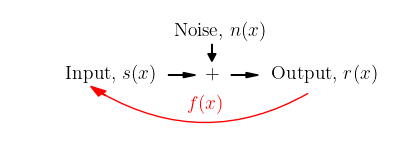

In [32]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(4.2,1.7))
ax.text(1 ,-0.05 ,r'Input, $s(x)$',fontsize=14,color='k', rotation=0)
ax.text(8.6 ,-0.05 ,r'Output, $r(x)$',fontsize=14,color='k', rotation=0)

ax.arrow(4.8,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(7.1,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(6.4,2,0,-1,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.text(6.17 ,-0.05 ,r'$+$',fontsize=14,color='k', rotation=0)
ax.text(5 ,2.5 ,r'Noise, $n(x)$',fontsize=14,color='k', rotation=0)
ax.axis('off')

ax.add_patch(patches.FancyArrowPatch(posA=(10, -0.8), posB=(2.3, -0.8), connectionstyle="angle3,angleA=30,angleB=150",
                                          lw=1, arrowstyle=u'|-|', color='r',
                                          mutation_scale=0))
ax.arrow(2.5,-1,-0.12,0.12,width=0.01,head_width=0.4,overhang=0,color='r',zorder=2)
ax.text(5.5 ,-1.8 ,r'$f(x)$',fontsize=14,color='r', rotation=0)

ax.set_xlim([-1,13])
ax.set_ylim([-4,4])
fig.tight_layout()
fig.savefig(str(savedir / 'LinSys_schema3.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Linear system diagram, function of (x)

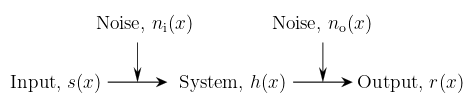

In [112]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc, FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(5,1.2))
ax.text(-12 ,0 ,r'Input, $s(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(12 ,0 ,r'Output, $r(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(0 ,0 ,r'System, $h(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(-6 ,3 ,r'Noise, $n_{\rm{i}}(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(6 ,3 ,r'Noise, $n_{\rm{o}}(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.arrow(-8.5,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(4,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(-6.5,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(6,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')

ax.set_xlim([-15,15])
ax.set_ylim([-0.7,3.7])
ax.axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'SystemID-diagram_x.pdf'), dpi=600, format='pdf', bbox_inches='tight')

### Linear system diagram, function of (t)

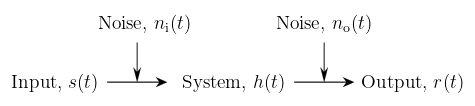

In [113]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc, FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(5,1.2))
ax.text(-12 ,0 ,r'Input, $s(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(12 ,0 ,r'Output, $r(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(0 ,0 ,r'System, $h(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(-6 ,3 ,r'Noise, $n_{\rm{i}}(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(6 ,3 ,r'Noise, $n_{\rm{o}}(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.arrow(-8.5,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(4,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(-6.5,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(6,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')

ax.set_xlim([-15,15])
ax.set_ylim([-0.7,3.7])
ax.axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'SystemID-diagram.pdf'), dpi=600, format='pdf', bbox_inches='tight')

### Deconvolution diagram

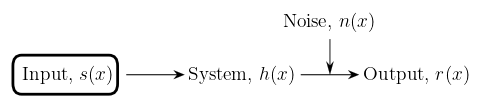

In [114]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc, FancyBboxPatch
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(5,1.2))
ax.text(-12 ,0 ,r'Input, $s(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(12 ,0 ,r'Output, $r(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(0 ,0 ,r'System, $h(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
# ax.text(-6 ,3 ,r'Noise, $n_{\rm{i}}(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(6 ,3 ,r'Noise, $n(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.arrow(-8,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(4,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
# ax.arrow(-6.5,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                # overhang=0.3,color='k')
ax.arrow(6,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
# Use FancyBboxPatch to create a rounded corner rectangle
box = FancyBboxPatch((-15.2, -0.5), 6, 1, edgecolor='k', facecolor='none', boxstyle='round,pad=0.6', linewidth=2)
ax.add_patch(box)

ax.set_xlim([-16,15])
ax.set_ylim([-1.2,3.7])
ax.axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'SystemID-deconv.pdf'), dpi=600, format='pdf', bbox_inches='tight')

### White noise analysis diagram

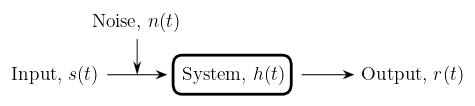

In [110]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc, FancyBboxPatch
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(5,1.2))
ax.text(-12 ,0 ,r'Input, $s(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(12 ,0 ,r'Output, $r(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(0 ,0 ,r'System, $h(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
# ax.text(-6 ,3 ,r'Noise, $n_{\rm{i}}(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(-6.5,3 ,r'Noise, $n(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.arrow(-8.5,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
ax.arrow(4.5,0,3.5,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
# ax.arrow(-6.5,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                # overhang=0.3,color='k')
ax.arrow(-6.5,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
# Use FancyBboxPatch to create a rounded corner rectangle
box = FancyBboxPatch((-3.5, -0.5), 6.7, 1, edgecolor='k', facecolor='none', boxstyle='round,pad=0.6', linewidth=2)
ax.add_patch(box)

ax.set_xlim([-15,15])
ax.set_ylim([-1.2,3.7])
ax.axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'SystemID-white-noise.pdf'), dpi=600, format='pdf', bbox_inches='tight')

### Wiener filter diagram

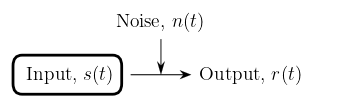

In [97]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc, FancyBboxPatch
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(3.5,1.2))
ax.text(-12 ,0 ,r'Input, $s(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(0 ,0 ,r'Output, $r(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
# ax.text(0 ,0 ,r'System, $h(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
# ax.text(-6 ,3 ,r'Noise, $n_{\rm{i}}(x)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
ax.text(-6 ,3 ,r'Noise, $n(t)$',fontsize=14,color='k', rotation=0, ha='center', va='center')
# ax.arrow(-8,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                # overhang=0.3,color='k')
ax.arrow(-8,0,4,0,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
# ax.arrow(-6.5,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                # overhang=0.3,color='k')
ax.arrow(-6,2,0,-2,width=0.05,length_includes_head=True,head_width=0.5,linewidth=0.1,
                overhang=0.3,color='k')
# Use FancyBboxPatch to create a rounded corner rectangle
box = FancyBboxPatch((-15.2, -0.5), 6, 1, edgecolor='k', facecolor='none', boxstyle='round,pad=0.6', linewidth=2)
ax.add_patch(box)

ax.set_xlim([-16,5])
ax.set_ylim([-1.2,3.7])
ax.axis('off')

fig.tight_layout()
fig.savefig(str(savedir / 'SystemID-Wiener.pdf'), dpi=600, format='pdf', bbox_inches='tight')

In [ ]:

# Use FancyBboxPatch to create a rounded corner rectangle
box = FancyBboxPatch((1.6, -1.3), 5, 2.9, edgecolor='k', facecolor='none', boxstyle='round,pad=0.1')
ax.add_patch(box)

ax.arrow(-2,0.2,2,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(0.3,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(7.1,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(-0.4,2,0,-1,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(2,2,0,-1,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.text(-3 ,2.5 ,r'Noise, $n_{\rm{i}}(x)$',fontsize=14,color='k', rotation=0)
ax.text(3 ,2.5 ,r'Noise, $n_{\rm{o}}(x)$',fontsize=14,color='k', rotation=0)
ax.axis('off')

ax.set_xlim([-8,13])
ax.set_ylim([-4,4])
fig.tight_layout()
fig.savefig(str(savedir / 'LinSys_schema4.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### White noise analysis

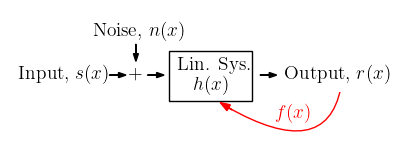

In [ ]:
from matplotlib.patches import Rectangle, Circle, Wedge, Arc
import matplotlib.patches as patches

fig,ax=plt.subplots(1,1,figsize=(4.2,1.7))
ax.text(-7.5 ,-0.05 ,r'Input, $s(x)$',fontsize=14,color='k', rotation=0)
ax.text(8.6 ,-0.05 ,r'Output, $r(x)$',fontsize=14,color='k', rotation=0)
ax.text(2.1 ,0.5 ,r'Lin. Sys.',fontsize=14,color='k', rotation=0)
ax.text(3.1 ,-0.7 ,r'$h(x)$',fontsize=14,color='k', rotation=0)
ax.add_patch(Rectangle((1.6, -1.3), 5,2.9,edgecolor='k',fill=False))
ax.arrow(-2,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(0.3,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(7.1,0.2,1,0,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.arrow(-0.4,2,0,-1,width=0.01,length_includes_head=True,head_width=0.3,
                overhang=0,color='k')
ax.text(-0.8 ,-0.05 ,r'$+$',fontsize=14,color='k', rotation=0)
ax.text(-3 ,2.5 ,r'Noise, $n(x)$',fontsize=14,color='k', rotation=0)
ax.axis('off')

ax.add_patch(patches.FancyArrowPatch(posA=(12, -0.4), posB=(5, -1.6), connectionstyle="angle3,angleA=80,angleB=150",
                                          lw=1, arrowstyle=u'|-|', color='r',
                                          mutation_scale=2))
ax.add_patch(patches.Rectangle((11.5,-0.8), 1, 1, angle=0.0, facecolor='w',alpha=1,zorder=1))
ax.add_patch(patches.Rectangle((-6.2,-1.4), 1, 1, angle=0.0, facecolor='w',alpha=1,zorder=1))
ax.arrow(5.4,-1.83,-0.2,0.12,width=0.01,head_width=0.4,overhang=0,color='r',zorder=2)
ax.text(8 ,-2.3 ,r'$f(x)$',fontsize=14,color='r', rotation=0)

ax.set_xlim([-8,13])
ax.set_ylim([-4,4])
fig.tight_layout()
fig.savefig(str(savedir / 'LinSys_schema4.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### System identification

In [4]:
# time axis for input and output
tx=np.arange(0,10,.01) 

# noise added to response
np.random.seed(0)
no=np.random.normal(size=len(tx)) # noise signal

# delta impulse at t=5 s
x1=1.0*(tx==5)

# impulse response
th=np.arange(0,1,.01)
n=2
tau=0.1
om=10
ph=0
h=(th/tau)**n * np.sin(om*th+ph) * np.exp(-th/tau)
y1=np.convolve(x1+0.01*no,h)[:len(tx)]

# sinusoid chirp
a=1
b=1.5
x2=np.sin(a*tx+b*tx**2)

# chirp response
y2=np.convolve(x2+0.1*no,h)[:len(tx)]

# white noise 
x3=np.random.normal(size=len(tx))

# white noise response
y3=np.convolve(x3+0.1*no,h)[:len(tx)]

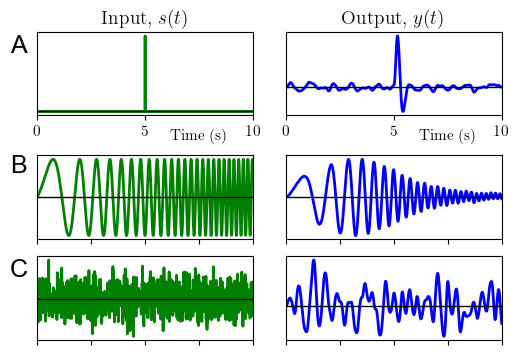

In [5]:
fig = plt.figure(figsize=(6,4))
    
# specify the grid of subplots
gs = fig.add_gridspec(2, 1, hspace=0.3, height_ratios=[0.9,2]) # spacing between the two groups
gs0 = gs[0].subgridspec(1, 2, hspace=0.1, wspace=0.15) # top group 1 x 2 panels
gs1 = gs[1].subgridspec(2, 2, hspace=0.2, wspace=0.15) # bottom group 2 x 2 panels
# make array of axes
ax=np.array([[fig.add_subplot(gs0[0,0]), fig.add_subplot(gs0[0,1])], [fig.add_subplot(gs1[0,0]), fig.add_subplot(gs1[0,1])], [fig.add_subplot(gs1[1,0]), fig.add_subplot(gs1[1,1])]])

a=ax[0,0]
a.plot(tx,x1,color='g',linewidth=2)
a.set_xlabel('Time (s)')
a.xaxis.set_label_coords(0.75, -0.15) # adjust the position of the x-axis label
a.set_xlim([0,10])
a.set_yticks([])
a.set_xticks([0,5,10])
# a.set_ylim([-0.1,1.1])  
a.set_title('Input, $s(t)$',fontsize=14,color='k')
a.axhline(y=0, color='k', linewidth=1)

a=ax[0,1]
a.plot(tx,y1,color='b',linewidth=2)
a.set_xlabel('Time (s)')
a.xaxis.set_label_coords(0.75, -0.15) # adjust the position of the x-axis label
a.set_xlim([0,10])
a.set_yticks([])
a.set_xticks([0,5,10])
# a.set_ylim([-0.1,1.1])  
a.set_title('Output, $y(t)$',fontsize=14,color='k')
a.axhline(y=0, color='k', linewidth=1)

a=ax[1,0]
a.plot(tx,x2,color='g',linewidth=2)
# a.set_xlabel('Time (s)')
a.set_xlim([0,10])
a.set_yticks([])
# a.set_ylim([-1.1,1.1])  
# a.set_title('Input, $s(t)$',fontsize=14,color='k')
a.axhline(y=0, color='k', linewidth=1)
a.xaxis.set_ticklabels([]);

a=ax[1,1]
a.plot(tx,y2,color='b',linewidth=2)
# a.set_xlabel('Time (s)')
a.set_xlim([0,10])
a.set_yticks([])
# a.set_ylim([-1.1,1.1])  
# a.set_title('Output, $y(t)$',fontsize=14,color='k')
a.axhline(y=0, color='k', linewidth=1)
a.xaxis.set_ticklabels([]);

a=ax[2,0]
a.plot(tx,x3,color='g',linewidth=2)
# a.set_xlabel('Time (s)')
a.set_xlim([0,10])
a.set_yticks([])
# a.set_ylim([-3,3])  
# a.set_title('Input, $s(t)$',fontsize=14,color='k')
a.axhline(y=0, color='k', linewidth=1)
a.xaxis.set_ticklabels([]);

a=ax[2,1]
a.plot(tx,y3,color='b',linewidth=2)
# a.set_xlabel('Time (s)')
a.set_xlim([0,10])
a.set_yticks([])
# a.set_ylim([-3,3])  
# a.set_title('Output, $y(t)$',fontsize=14,color='k')
a.axhline(y=0, color='k', linewidth=1)
a.xaxis.set_ticklabels([]);

matplotlib.rcParams['text.usetex'] = False # Want to use non-latex font
fig.text(0.08, 0.83, 'A', fontsize=18, fontname='Arial'); 
fig.text(0.08, 0.53, 'B', fontsize=18, fontname='Arial'); 
fig.text(0.08, 0.27, 'C', fontsize=18, fontname='Arial'); 
matplotlib.rcParams['text.usetex'] = True

fig.savefig(str(savedir / 'System_ID.pdf'), format='pdf', bbox_inches='tight');

### Sampling theorem

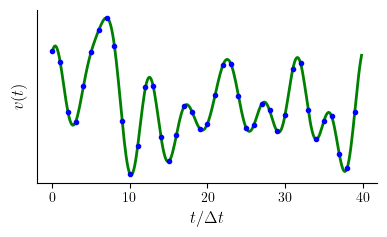

In [25]:
# a signal sampled at 2x the Nyquist rate
from scipy import signal
n=40 # number of samples
m=8 # smoothing
np.random.seed(0)
y1=np.random.normal(0,1,n//2) # gaussian random noise
y2=signal.resample(y1,n) # upsample y1 by a factor of 2 (2 * Nyquist)
y3=signal.resample(y2,n*m) # upsample y2 by another factor of m
x2=np.arange(0,n) # sample number
x3=np.arange(0,n,1/m) # x for smooth curve
fig, ax = plt.subplots(figsize=(4,2.5))
plot([x3,x2],[y3,y2],fmts=['g-','bo'],
    markersize=3,
    xlabel=r'$t/\Delta t$',
    ylabel=r'$v(t)$',
    yticks=[],
    axes=ax
);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'sampling.pdf'), dpi=600, format='pdf', bbox_inches='tight');

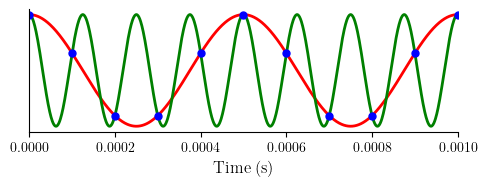

In [26]:
w1=2*np.pi*2000 # radial frequency 2000 Hz
w2=2*np.pi*8000 # radial frequency 8000 Hz
x=np.arange(0,1e-3,1e-6) # time axis 1 ms
y1=np.cos(w1*x) # one sine wave
y2=np.cos(w2*x) # the other sine wave
t=np.arange(11)*1e-4 # sample times at 10,000 Hz
y3=np.cos(w1*t) # values of those samples
fig, ax = plt.subplots(figsize=(5,2))
plot(x,[y1,y2],fmts=['r-','g-'],axes=ax)
plot(t,y3,fmts=['bo'],axes=ax,yhide=True,xlim=[0,1e-3],xlabel='Time (s)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'aliasing.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Solving differential equations

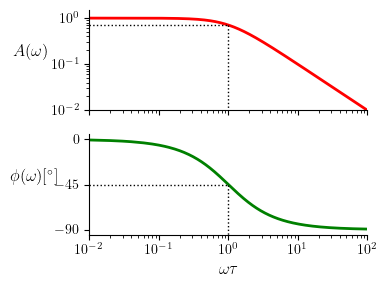

In [27]:
x = np.arange(0.01,100,0.01)
y = 1/(1+x*1j)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,3))
plot(x, np.abs(y), ylabel=r'$A(\omega)$',
          xlim=(0.01,100), xscale='log',
          ylim=(0.01,1.5), yscale='log',
          fmts=['r-'],
          yrot=True, axes=axes[0])
plot(x, np.angle(y)*180/np.pi, xlabel=r'$\omega\tau$', ylabel=r'$\phi(\omega) [^{\circ}]$',
          xlim=(0.01,100), xscale='log',
          ylim=(-95,5), yticks=[-90,-45,0],
          fmts=['g-'],
          yrot=True,axes=axes[1])

axes[0].plot([0.01,1], [np.sqrt(0.5),np.sqrt(0.5)], color='black', linestyle='dotted', linewidth=1)
axes[0].plot([1,1], [np.sqrt(0.5),0.01], color='black', linestyle='dotted', linewidth=1)
axes[1].plot([0.01,1], [-45,-45], color='black', linestyle='dotted', linewidth=1)
axes[1].plot([1,1], [-45,-95], color='black', linestyle='dotted', linewidth=1)

axes[0].tick_params(labelbottom=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(str(savedir / 'rc_bode.pdf'), dpi=600, format='pdf', bbox_inches='tight');

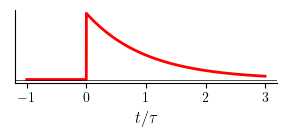

In [28]:
x = np.arange(-1, 3, 0.001)
y = np.exp(-x)
y[x<0]=0
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y, xlabel=r'$t/\tau$', yzero=True, yhide=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'rc_impulse.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Separating signal from noise

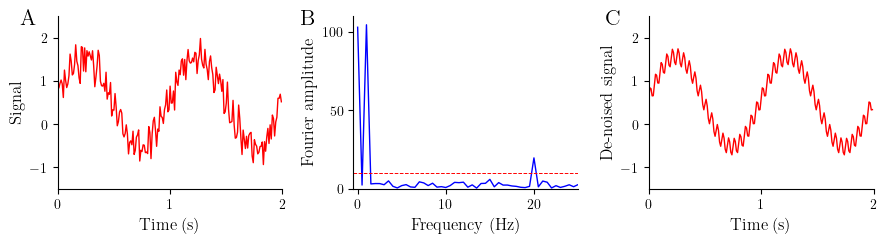

In [103]:
np.random.seed(0) # make the simulation reproducible
x = np.arange(0, 2, 0.01)
y = 0.5+np.sin(2*np.pi*x)+0.2*np.sin(20*2*np.pi*x)+0.2*np.random.randn(len(x)) # 1 Hz sine wave plus small 20 Hz sine wave plus random gaussian nosie
fy = np.fft.rfft(y) # Fourier transform 
om = np.fft.rfftfreq(len(y),0.01) # Frequencies
ay = np.abs(fy) # Fourier amplitude
fz = np.copy(fy) # prepare F.T. of the filtered signal
fz[ay<10]=0 # set to zero all components below a threshold of ay=10
z = np.fft.irfft(fz) # inverse transform that
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5))
plot(x, y, xlim=[0,2], ylim=[-1.5,2.5], xticks=[0,1,2], linewidth=1, 
  xlabel='Time (s)', ylabel='Signal', axes=axes[0]);
plot(om, ay, fmts=['b-'], xlim=[-2,25], ylim=[0,110], yticks=[0,50,100], linewidth=1, 
  xlabel='Frequency (Hz)', ylabel='Fourier amplitude',axes=axes[1]);
axes[1].axhline(y=10, linestyle='--', color='r', linewidth=0.7);
plot(x, z, xlim=[0,2], ylim=[-1.5,2.5], xticks=[0,1,2], linewidth=1, 
  xlabel='Time (s)', ylabel='De-noised signal',axes=axes[2]);
axes[1].set_xlim([-0.5,25]);
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.subplots_adjust(bottom=0.15)
fig.tight_layout();
fig.text(0.03, 0.9, "A", fontsize=16, fontweight="bold")
fig.text(0.34, 0.9, "B", fontsize=16, fontweight="bold")
fig.text(0.68, 0.9, "C", fontsize=16, fontweight="bold")
fig.savefig(str(savedir / 'sin_noise.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Filtering
Use the same signal but low-pass filter it to remove the high frequency noise.

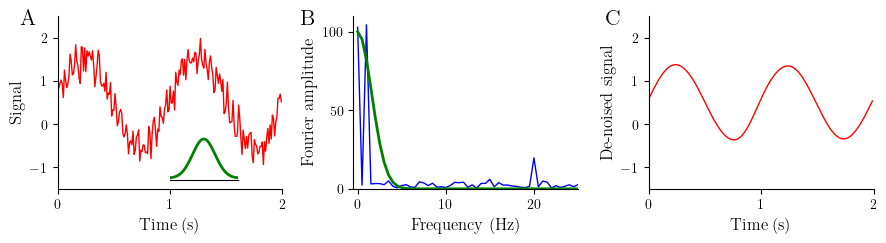

In [104]:
np.random.seed(0) # make the simulation reproducible
x = np.arange(0, 2, 0.01)
y = 0.5+np.sin(2*np.pi*x)+0.2*np.sin(20*2*np.pi*x)+0.2*np.random.randn(len(x)) # 1 Hz sine wave plus small 20 Hz sine wave plus random gaussian noise
fy = np.fft.rfft(y) # Fourier transform 
om = np.fft.rfftfreq(len(y),0.01) # Frequencies
ay = np.abs(fy) # Fourier amplitude

tau=0.1 # width of gaussian filter
xg = np.arange(-1, 1, 0.01)
g = np.exp(-xg**2/2/tau**2) # gaussian filter
g /= np.sum(g) # normalize the filter
fg = np.fft.rfft(g) # Fourier transform 
og = np.fft.rfftfreq(len(g),0.01) # Frequencies
ag = np.abs(fg) # Fourier amplitude

z = np.fft.irfft(fy * fg) # convolve signal with filter

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5))

# Add an inset axis to the first panel
inset_ax = axes[0].inset_axes([0.5, 0.05, 0.3, 0.25])
inset_ax.plot(xg, g, linewidth=2, color='g')
inset_ax.set_xlim(0.3*2*np.array([-0.5,.5]))
# inset_ax.set_ylim([-0.5, 0.5])
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
# inset_ax.spines['bottom'].set_visible(False)
inset_ax.spines['left'].set_visible(False)
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# Plot the rest of the figures
plot(x, y, xlim=[0,2], ylim=[-1.5,2.5], xticks=[0,1,2], linewidth=1, 
  xlabel='Time (s)', ylabel='Signal', axes=axes[0]);
plot(om, ay, fmts=['b-'], xlim=[-2,25], ylim=[0,110], yticks=[0,50,100], linewidth=1, 
  xlabel='Frequency (Hz)', ylabel='Fourier amplitude',axes=axes[1]);
plot(om, ag*100/np.max(ag), fmts=['g-'], xlim=[-2,25], ylim=[0,110], yticks=[0,50,100], linewidth=2, 
  xlabel='Frequency (Hz)', ylabel='Fourier amplitude',axes=axes[1]);
plot(x, z, xlim=[0,2], ylim=[-1.5,2.5], xticks=[0,1,2], linewidth=1, 
  xlabel='Time (s)', ylabel='De-noised signal',axes=axes[2]);
axes[1].set_xlim([-0.5,25]);
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.subplots_adjust(bottom=0.15)
fig.tight_layout();
fig.text(0.03, 0.9, "A", fontsize=16, fontweight="bold")
fig.text(0.34, 0.9, "B", fontsize=16, fontweight="bold")
fig.text(0.68, 0.9, "C", fontsize=16, fontweight="bold")
fig.savefig(str(savedir / 'sin-lowpass.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Analysis of a cell cycle experiment

As of Nov 7, 2023, this server can't be reached anymore. But the data are archived in other places, for example:
- https://www.yeastgenome.org/dataset/Spellman_1998_PMID_9843569
- https://gen-files.princeton.edu/sgdlite/yeast_datasets/
- https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE23

In [3]:
# check if we've downloaded this previously
try: 
    text = np.genfromtxt(str(datadir / 'stanford-cell-cycles.txt'), dtype=None, delimiter='\t',
                         encoding=None)
# otherwise get it from the web
except IOError: 
    url = ("http://genome-www.stanford.edu/cellcycle"
           "/data/rawdata/combined.txt")
    text = np.genfromtxt(url, dtype=None, delimiter='\t',
                         encoding=None) 

# names of the genes
name = text[1:6379,0].astype('str') 
# activations during the alpha series
data = text[1:6379,7:25] 
# replace empty strings with zero
data[data=='']='0' 
# convert data type to float
data = data.astype(float)
# m = num of genes, n = num of time points
(m,n) = data.shape 

In [4]:
m,n

(6178, 18)

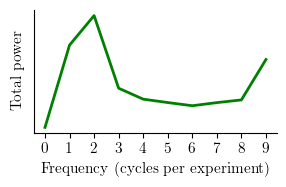

In [8]:
# Fourier transform all genes
ft = np.fft.rfft(data)
# frequency in 'cycles per experiment'
om = np.fft.rfftfreq(n, 1/n) 
# power
fp = np.abs(ft)**2 
# sum power over all genes
fa = fp.sum(axis=0) 
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(om, fa,color='g',linewidth=2)
ax.set_xlabel('Frequency (cycles per experiment)')
ax.set_ylabel('Total power')
ax.set_xticks(range(10))
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(str(savedir / 'cell-cycle-ft.pdf'), dpi=600, format='pdf', bbox_inches='tight');

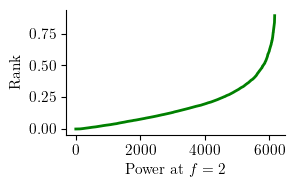

In [10]:
# total power for each gene
pt = np.sum(fp, axis=1)
# to avoid div by zero error
pt[pt==0] = float('inf')
# relative power at f=2
p2 = fp[:,2]/pt 
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(p2[np.argsort(p2)],color='g',linewidth=2)
ax.set_xlabel('Power at $f=2$')
ax.set_ylabel('Rank')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
fig.savefig(str(savedir / 'cell-cycle-power.pdf'), dpi=600, format='pdf', bbox_inches='tight');

In [12]:
# number of genes with highest modulation at f=2
ntop = 800 
# sort in decreasing order of p2
so = np.flip(np.argsort(p2))[:ntop] 
# keep the top ntop genes
z = data[so,:] 
fz = ft[so,:] 
# keep track of gene names as well
nz = name[so] 

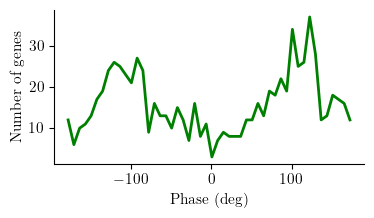

In [13]:
# phase at frequency=2 in deg
ph = np.angle(fz[:,2])*180/np.pi 
h,b = np.histogram(ph,bins=50)
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(b[:-1], h, color='g',linewidth=2)
ax.set_xlabel('Phase (deg)')
ax.set_ylabel('Number of genes')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(str(savedir / 'cell-cycle-phase.pdf'), dpi=600, format='pdf', bbox_inches='tight');

In [68]:
sp = np.flip(np.argsort(ph)) # decreasing order of phase
z = z[sp,:] # sort data according to the phase
fz = fz[sp,:]
nz = nz[sp]

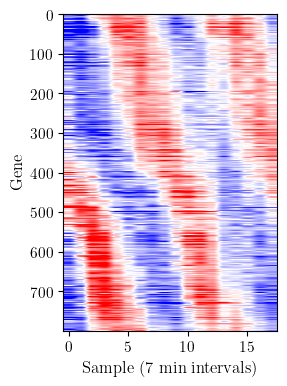

In [73]:
clip = 0.8
fig, ax = plt.subplots(figsize=(3,4))
ax.imshow(z, aspect='auto', cmap='bwr', vmin=-clip, vmax=clip);
ax.set_xlabel('Sample (7 min intervals)', fontsize=12);
ax.set_ylabel('Gene', fontsize=12);
plt.tight_layout()
fig.savefig(str(savedir / 'cell-cycle-heatmap.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Exercises